# Planning

* **Input**
  * Base kc_house_data encontrada no kaggle com dados de preço de venda de casas em King County, WA, EUA
* **Output**
  * Análise com preço sugerido de venda de cada imóvel
  * Sugestão de melhor época do ano para venda de imóveis
* **Tasks**
  * Análisar as features disponíveis
  * Tratar os dados faltantes
  * Tratar os tipos de dados incorretos
  * Criar novas features
  * Selecionar as features

# Imports

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate as tab
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

# Funções Auxiliares

In [10]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
def ml_error(model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y, yhat))
  
  return pd.DataFrame(
      {
          'Model Name': model_name,
          'MAE': mae,
          'MAPE': mape,
          'RMSE': rmse
      }, 
      index=[0])

def ml_cross_validation_error(model, model_name):
    
    header = ['Model Name', 'MAE', 'MAPE', 'RMSE']
    e_data = {}

    for m in score_metrics:
        aux1 = np.round(np.mean(model['test_' + m]), 2).astype(str)
        aux1 += ' +/- '
        aux1 += np.round(np.std(model['test_' + m]), 2).astype(str)
        
        e_data[m] = aux1

    r_error = {'Model Name': model_name}

    r_error.update(e_data)

    df_aux1 = pd.DataFrame(
        r_error,
        index=[0]
    )

    df_aux1.columns = header

    return df_aux1

In [11]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Definitions

In [12]:
main_path = '/home/bem/repos/python_zero_ao_ds/'
raw_data_path = main_path + 'data/raw/'
image_path = main_path + 'assets/images/'

raw_data = 'kc_house_data.csv'
raw_data_file = raw_data_path + raw_data

mind_map_img = 'mind_map_hypothesis.png'
mind_map_file = image_path + mind_map_img

score_metrics = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']

# Data Load

In [13]:
df = pd.read_csv(raw_data_file)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [14]:
table = [
  ['Feature', 'Description'],
  ['id', 'Unique ID for each home sold'],
  ['date', 'Date of the home sale'],
  ['price', 'Price of each home sold'],
  ['bedrooms', 'Number of bedrooms'],
  ['bathrooms', 'Number of bathrooms, where .5 accounts for a room with a toilet but no shower'],
  ['sqft_living', 'Square footage of the apartments interior living space'],
  ['sqft_lot', 'Square footage of the land space'],
  ['floors', 'Number of floors'],
  ['waterfront', 'A dummy variable for whether the apartment was overlooking the waterfront or not'],
  ['view', 'An index from 0 to 4 of how good the view of the property was'],
  ['condition', 'An index from 1 to 5 on the condition of the apartment'],
  ['grade', 'An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an\naverage level of construction and design, and 11-13 have a high quality level of construction\nand design'],
  ['sqft_above', 'The square footage of the interior housing space that is above ground level'],
  ['sqft_basement', 'The square footage of the interior housing space that is below ground level'],
  ['yr_built', 'The year the house was initially built'],
  ['yr_renovated', 'The year of the house’s last renovation'],
  ['zipcode', 'What zipcode area the house is in'],
  ['lat', 'Lattitude'],
  ['long', 'Longitude'],
  ['sqft_living15', 'The square footage of interior housing living space for the nearest 15 neighbors'],
  ['sqft_lot15', 'The square footage of the land lots of the nearest 15 neighbors']
]

print(tab(table, tablefmt='fancy_grid', headers='firstrow'))

╒═══════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════╕
│ Feature       │ Description                                                                                   │
╞═══════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════╡
│ id            │ Unique ID for each home sold                                                                  │
├───────────────┼───────────────────────────────────────────────────────────────────────────────────────────────┤
│ date          │ Date of the home sale                                                                         │
├───────────────┼───────────────────────────────────────────────────────────────────────────────────────────────┤
│ price         │ Price of each home sold                                                                       │
├───────────────┼───────────────────────────────────────────────────────────────────────

# 1.0. Descrição dos Dados

## 1.1. Renomear features

Não há necessidade, o padrão que utilizo é o mesmo que a base se encontra: snake_case

## 1.2. Dimensões do dataset

In [15]:
df.shape

(21613, 21)

## 1.3. Tipos de dados

In [16]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Há apenas uma feature com o tipo de dados incompatível com o dado armazenado.
Conversão a ser executada:
- date -> object para datetime

## 1.4. Dados faltantes

In [17]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Não há dados faltantes no dataset

## 1.5. Tratamento dos dados faltantes

Como não há dados faltantes, este passo não será executado

## 1.6. Conversões de tipos de dados

In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 1.7. Estatística Descritiva

In [20]:
num_attributes = df.select_dtypes(include=['int64', 'float64'])
cat_attributes = df.select_dtypes(exclude=['int64', 'float64', 'datetime64'])

num_attributes = num_attributes.drop(columns=['id'], axis=1)

In [21]:
# Localização: média e mediana
m1 = pd.DataFrame(num_attributes).apply(np.mean).T
m2 = pd.DataFrame(num_attributes).apply(np.median).T

# Dispersão: min, max, range, std
m3 = pd.DataFrame(num_attributes).apply(min).T
m4 = pd.DataFrame(num_attributes).apply(max).T
m5 = pd.DataFrame(num_attributes).apply(lambda x: x.max() - x.min()).T

# Skew
m6 = pd.DataFrame(num_attributes).apply(lambda x: x.skew()).T

# Kurtosis
m7 = pd.DataFrame(num_attributes).apply(lambda x: x.kurtosis()).T

df_stats = pd.concat([m3, m4, m5, m1, m2, m6, m7], axis=1).reset_index()
df_stats.columns = ['atributo', 'min', 'max', 'range', 'media', 'mediana', 'skew', 'kurtosis']

df_stats

,atributo,min,max,range,media,mediana,skew,kurtosis
0,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,4.02,34.59
1,bedrooms,0.00,33.00,33.00,3.37,3.00,1.97,49.06
2,bathrooms,0.00,8.00,8.00,2.11,2.25,0.51,1.28
3,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,1.47,5.24
4,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,13.06,285.08
5,floors,1.00,3.50,2.50,1.49,1.50,0.62,-0.48
6,waterfront,0.00,1.00,1.00,0.01,0.00,11.39,127.63
7,view,0.00,4.00,4.00,0.23,0.00,3.40,10.89
8,condition,1.00,5.00,4.00,3.41,3.00,1.03,0.53
9,grade,1.00,13.00,12.00,7.66,7.00,0.77,1.19


# 2.0. Feature engineering

In [22]:
df2 = df.copy()

## 2.1. Criação de features

Derivação de features para facilitar a análise

In [23]:
# waterfront : 0 = no | 1 = yes
df2['waterfront_cat'] = df2['waterfront'].apply(lambda x: 'yes' if x == 1 else 'no')

# 2view: 0-1 = bad | 2-3 = regular | 4 = good
df2['view_cat'] = df2['view'].apply(lambda x: 'bad' if x < 2 else 'good' if x == 4 else 'regular')

# 2condition: 0-2 = bad | 3-4 = regular | 5 = good
df2['condition_cat'] = df2['condition'].apply(lambda x: 'bad' if x < 3 else 'good' if x == 5 else 'regular')

# 2grade: 1-3 = low | 4-10 = medium | 11-13 high
df2['grade_cat'] = df2['grade'].apply(lambda x: 'low' if x < 4 else 'high' if x > 10 else 'medium')

# 2yr_built: < 2014 = old | >= 2014 = new
df2['built_cat'] = df2['yr_built'].apply(lambda x: 'old' if x < 2014 else 'new')

# 2season (month): 12, 1, 2 = winter | 3, 4, 5 = spring | 6, 7, 8 = summer | 9, 10, 11 = autumn
df2['season'] = df2['date'].apply(lambda x:
                                    'spring' if (x.month >= 3) & (x.month <= 5) else
                                    'summer' if (x.month >= 6) & (x.month <= 8) else
                                    'autumn' if (x.month >= 9) & (x.month <= 11) else
                                    'winter')

In [24]:
cols = ['waterfront', 'waterfront_cat',
        'view', 'view_cat',
        'condition', 'condition_cat',
        'grade', 'grade_cat',
        'yr_built', 'built_cat',
        'date', 'season']

df2[cols].sample(10)

,waterfront,waterfront_cat,view,view_cat,condition,condition_cat,grade,grade_cat,yr_built,built_cat,date,season
8299,0,no,0,bad,4,regular,7,medium,1951,old,2014-05-13,spring
11447,0,no,2,regular,4,regular,9,medium,1976,old,2015-01-02,winter
4598,0,no,0,bad,3,regular,7,medium,1971,old,2014-11-18,autumn
16702,0,no,0,bad,4,regular,8,medium,1953,old,2014-10-30,autumn
13704,0,no,0,bad,3,regular,8,medium,1962,old,2014-07-22,summer
13500,0,no,0,bad,3,regular,7,medium,1981,old,2014-10-28,autumn
12755,0,no,0,bad,3,regular,8,medium,1957,old,2014-08-19,summer
3850,0,no,0,bad,3,regular,7,medium,1986,old,2014-10-03,autumn
15981,0,no,0,bad,4,regular,6,medium,1967,old,2015-01-27,winter
18594,0,no,0,bad,3,regular,11,high,1992,old,2014-07-08,summer


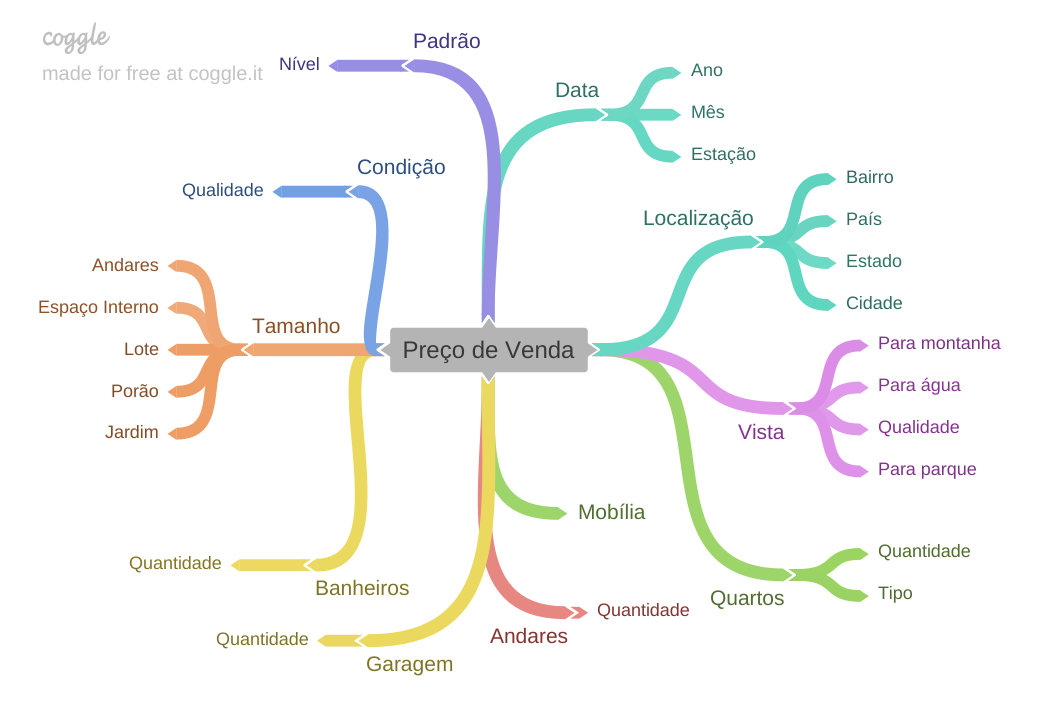

In [25]:
Image(mind_map_file)

## 2.2. Hipóteses de negócio

**H1.** Propriedades com vista para o lago são mais caras  
**H2.** Propriedades com mais quartos são mais caras  
**H3.** O preço das propriedades aumenta conforme o tamanho interno da propriedade aumenta  
**H4.** Propriedades térreas são mais caras  
**H5.** Propriedades em más condições são mais baratas  
**H6.** Propriedades de alto padrão são mais caras  
**H7.** Propriedades de alto padrão mesmo em más condições são mais caras do que propriedades de baixo padrão em boas condições  
**H8.** Propriedades com vista para o lago com qualquer qualidade são mais caras do que propriedades com vista da melhor qualidade  
**H9.** Propriedades de alto padrão com vista para o lago e de boa qualidade e em boas condições são raras, compõem apenas 10% da base  
**H10.** O preço das casas diminui com a idade  
**H11.** Propriedades com vista para o lago são vendidas no verão por 15% a mais no valor médio de venda do que em outras estações  
**H12.** No geral, a época do ano não gera mais de 5% de variação no preço médio de venda entre as estações

# 3.0. Filtro de features

Neste ponto vou tratar apenas as duplicidades de ID mantendo o último registro adicionado à base.

In [26]:
df3 = df2.copy()

df3 = df3.drop_duplicates(subset=['id'], keep='last')

# 4.0. Análise exploratória dos dados

In [27]:
df4 = df3.copy()

## 4.1. Análise univariada

Preço de venda

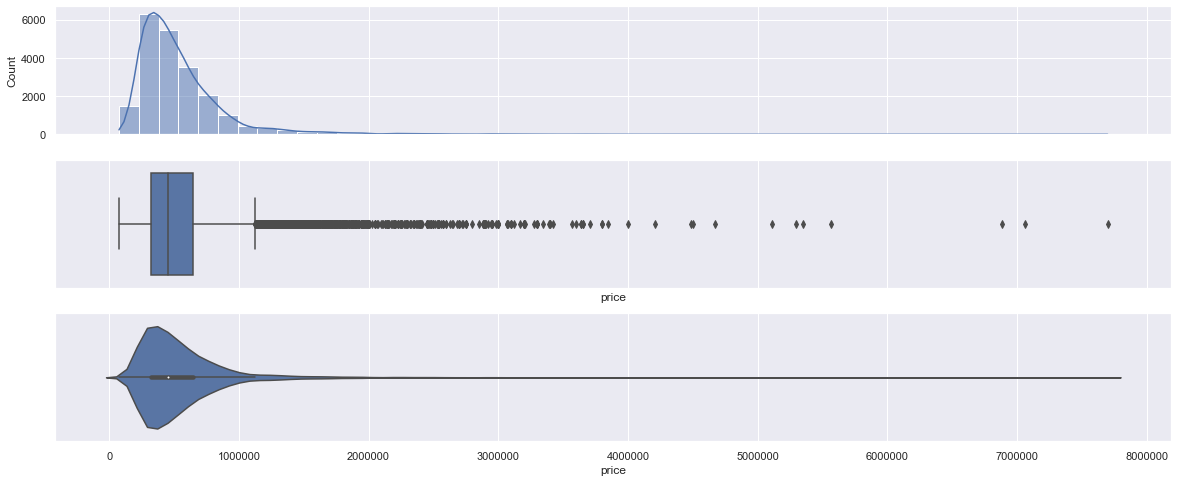

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

sns.histplot(data=df4, x='price', bins=50, ax=ax[0], kde=True)
sns.boxplot(data=df4, x='price', orient='h', ax=ax[1])
sns.violinplot(data=df4, x='price', orient='h', ax=ax[2]);

plt.ticklabel_format(style='plain', axis='x')

In [29]:
# Cálculo para encontrar o número onde os whikers do boxplot estão localizados
q1, q3 = df4['price'].quantile([0.25, 0.75])
outlier_cut = q3 + (1.5 * (q3 - q1))

# assim é possível checar os dados que estão acima desses possíveis outliers
df4.loc[df4['price'] >= outlier_cut]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_cat,view_cat,condition_cat,grade_cat,built_cat,season
5,7237550310,2014-05-12,1225000.00,4,4.50,5420,101930,1.00,0,0,3,11,3890,1530,2001,0,98053,47.66,-122.00,4760,101930,no,bad,regular,high,old,spring
21,2524049179,2014-08-26,2000000.00,3,2.75,3050,44867,1.00,0,4,3,9,2330,720,1968,0,98040,47.53,-122.23,4110,20336,no,good,regular,medium,old,summer
49,822039084,2015-03-11,1350000.00,3,2.50,2753,65005,1.00,1,2,5,9,2165,588,1953,0,98070,47.40,-122.45,2680,72513,yes,regular,good,medium,old,spring
69,1802000060,2014-06-12,1325000.00,5,2.25,3200,20158,1.00,0,0,3,8,1600,1600,1965,0,98004,47.63,-122.22,3390,20158,no,bad,regular,medium,old,summer
125,4389200955,2015-03-02,1450000.00,4,2.75,2750,17789,1.50,0,0,3,8,1980,770,1914,1992,98004,47.61,-122.21,3060,11275,no,bad,regular,medium,old,spring
153,7855801670,2015-04-01,2250000.00,4,3.25,5180,19850,2.00,0,3,3,12,3540,1640,2006,0,98006,47.56,-122.16,3160,9750,no,regular,regular,high,old,spring
216,46100204,2015-02-21,1505000.00,5,3.00,3300,33474,1.00,0,3,3,9,1870,1430,1957,1991,98040,47.57,-122.21,3836,20953,no,regular,regular,medium,old,winter
246,2025069065,2014-09-29,2400000.00,4,2.50,3650,8354,1.00,1,4,3,9,1830,1820,2000,0,98074,47.63,-122.07,3120,18841,yes,good,regular,medium,old,autumn
269,7960900060,2015-05-04,2900000.00,4,3.25,5050,20100,1.50,0,2,3,11,4750,300,1982,2008,98004,47.63,-122.22,3890,20060,no,regular,regular,high,old,spring
270,4054500390,2014-10-07,1365000.00,4,4.75,5310,57346,2.00,0,0,4,11,5310,0,1989,0,98077,47.73,-122.04,4180,47443,no,bad,regular,high,old,autumn


Plot de todas as features numéricas para checar a distribuição

In [30]:
# atualizando o df de categorias para incluir as novas features criadas no feature engineering
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64'])

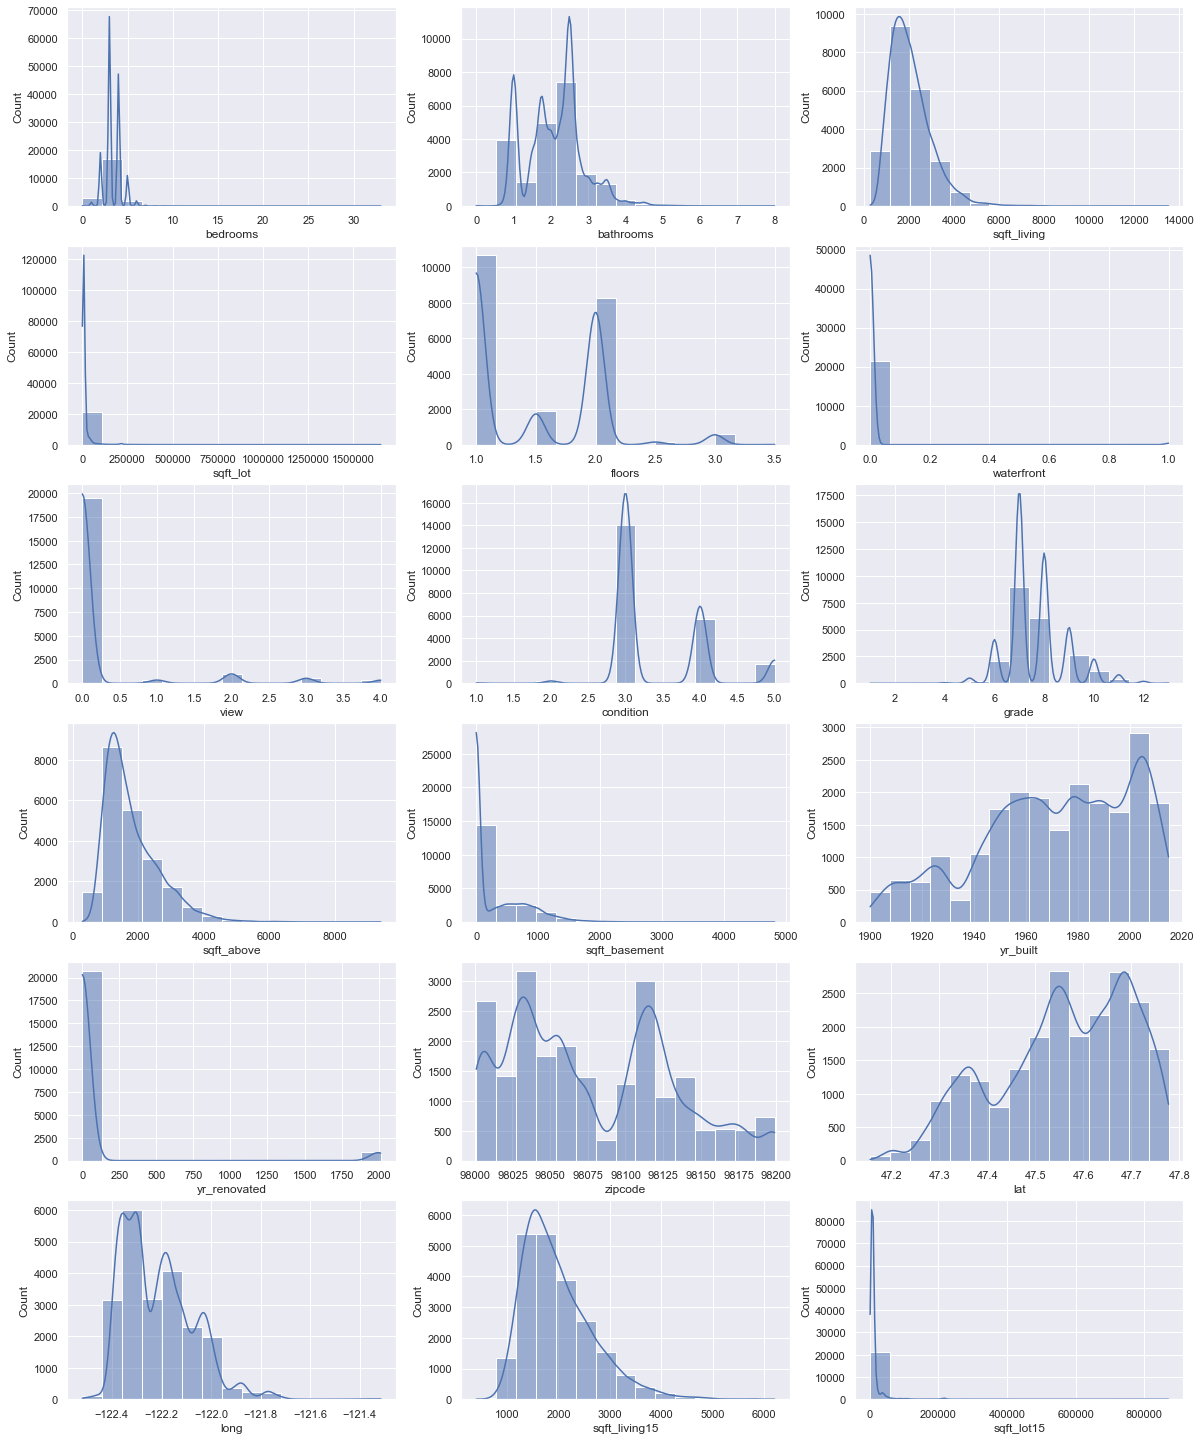

In [31]:
aux = num_attributes.drop(columns=['price'], axis=1)

plt.figure(figsize=(20, 30))
x = 1
for f in aux:
    plt.subplot(7, 3, x)
    sns.histplot(data=aux, x=f, bins=15, kde=True)
    plt.ticklabel_format(style='plain', axis='x')
    x += 1

É possível notar que o dataset está bem desbalanceado, apenas uma feature (sqft_living15) se aproxima de uma distribuição normal.
As demais apresentam um comportamento irregular e com caldas muito longas, o que indica possível presença de outliers.  
Além disso, algumas features numéricas se comportam como variáveis categóricas então não é possível ter uma noção apenas olhando o histograma.

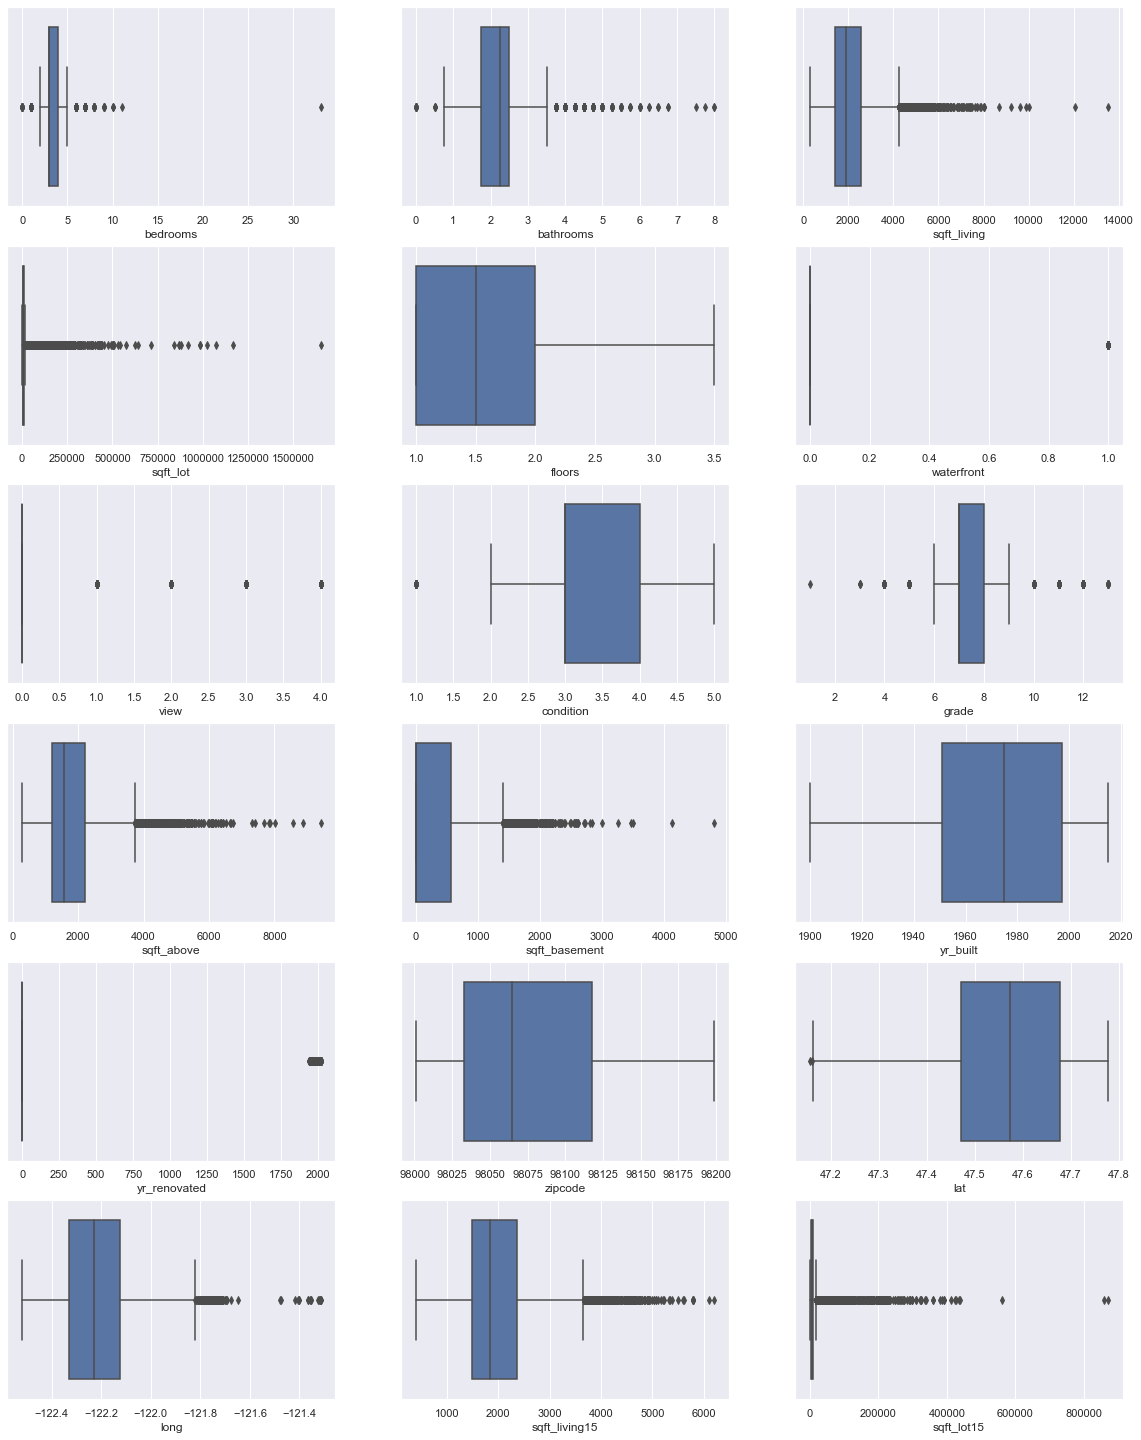

In [32]:
plt.figure(figsize=(20, 30))
x = 1
for f in aux:
    plt.subplot(7, 3, x)
    sns.boxplot(data=aux, x=f, orient='h')
    plt.ticklabel_format(style='plain', axis='x')
    x += 1

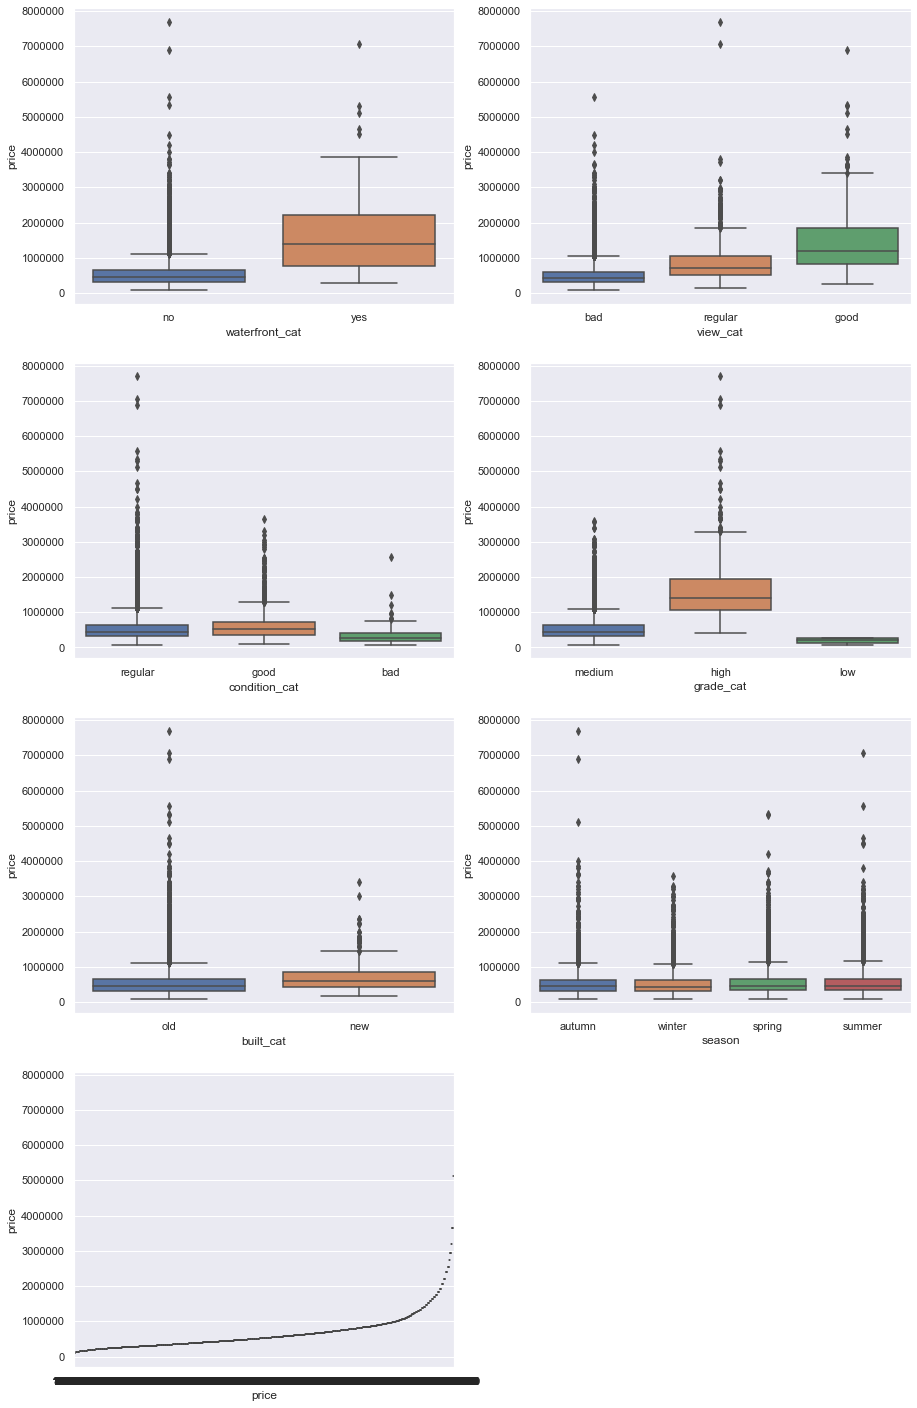

In [33]:
aux = pd.merge(cat_attributes, num_attributes['price'], how='inner', left_index=True, right_index=True)

plt.figure(figsize=(15, 25))
x = 1
for f in aux:
    plt.subplot(4, 2, x)
    sns.boxplot(data=aux, x=f, y='price')
    plt.ticklabel_format(style='plain', axis='y')
    x += 1

## 4.2. Análise bivariada

### H1. Propriedades com vista para o lago são mais caras

#### TRUE

Propriedades com vista para o lago tem o preço médio mais alto do que propriedades sem vista para o lago.

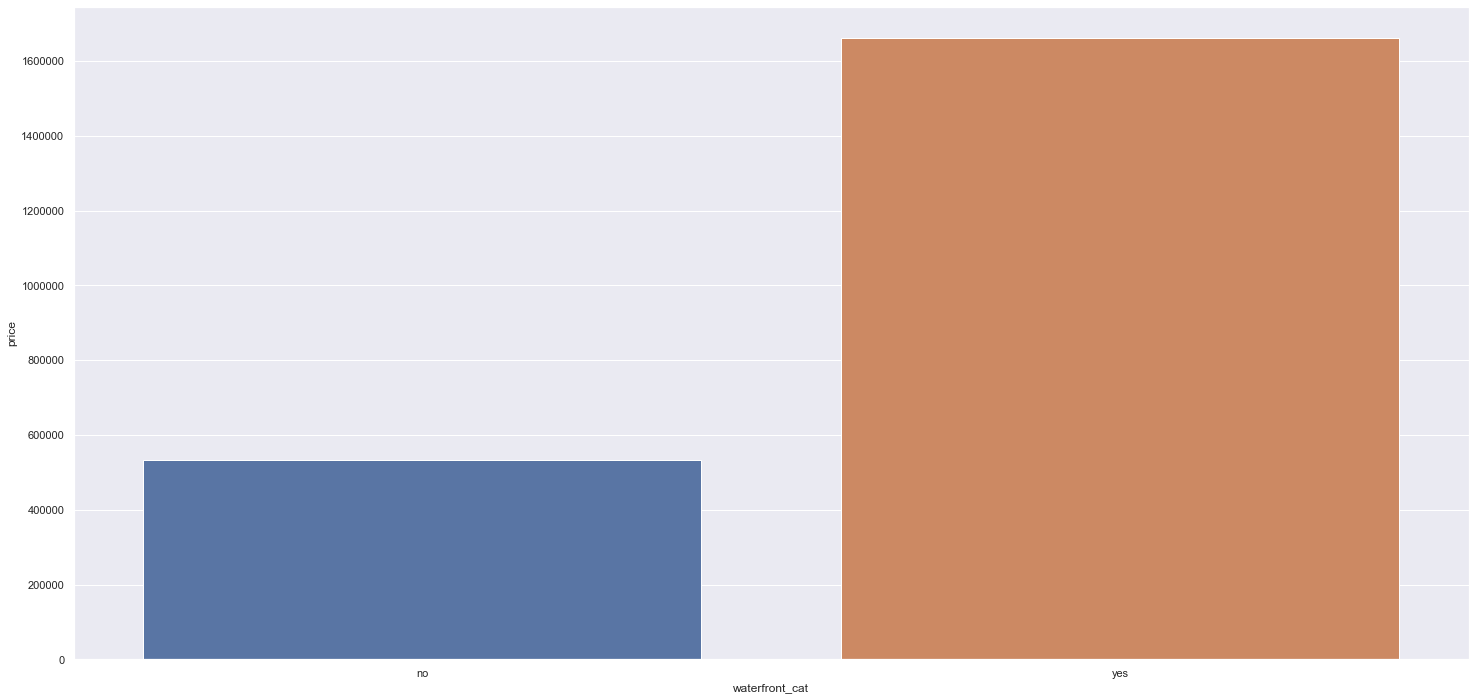

In [34]:
aux = df4[['waterfront_cat', 'price']].groupby('waterfront_cat', as_index=False).mean()
sns.barplot(data=aux, x='waterfront_cat', y='price')
plt.ticklabel_format(style='plain', axis='y');

### H2. Propriedades com mais quartos são mais caras

#### FALSE

Não necessariamente. O maior preço médio de venda está nas propriedades de 8, 7 e 9 quartos. Enquanto na base existem propriedades de 10, 11 e até 33 quartos com o valor médio de venda menor do que o primeiro grupo.

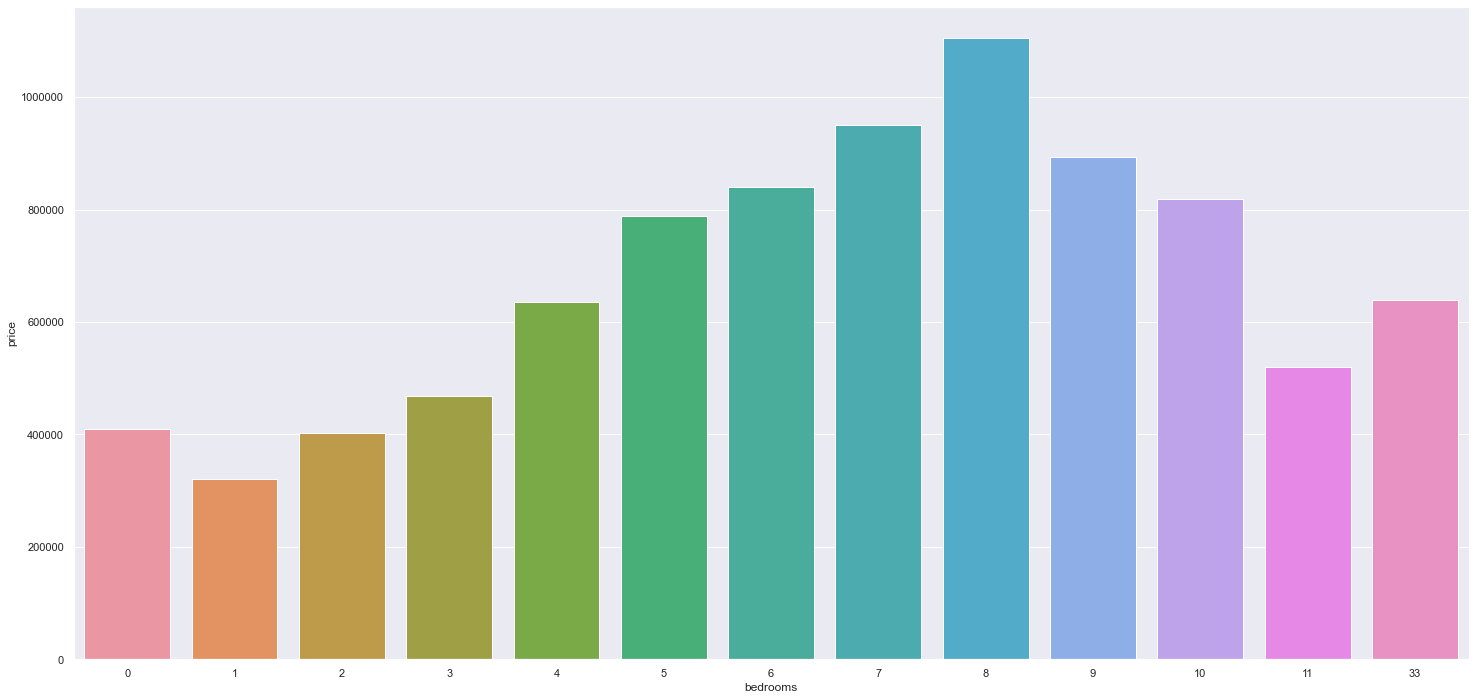

In [35]:
aux = df4[['bedrooms', 'price']].groupby('bedrooms', as_index=False).mean()
sns.barplot(data=aux, x='bedrooms', y='price')
plt.ticklabel_format(style='plain', axis='y');

### H3. O preço das propriedades aumenta conforme o tamanho interno da propriedade aumenta.

#### TRUE

A tendência mostra um correlação relevante e positiva entre o preço de venda e tamanho interno da propriedade. Então, quando o tamanho interno de uma propriedade aumenta, o preço de venda também aumenta.

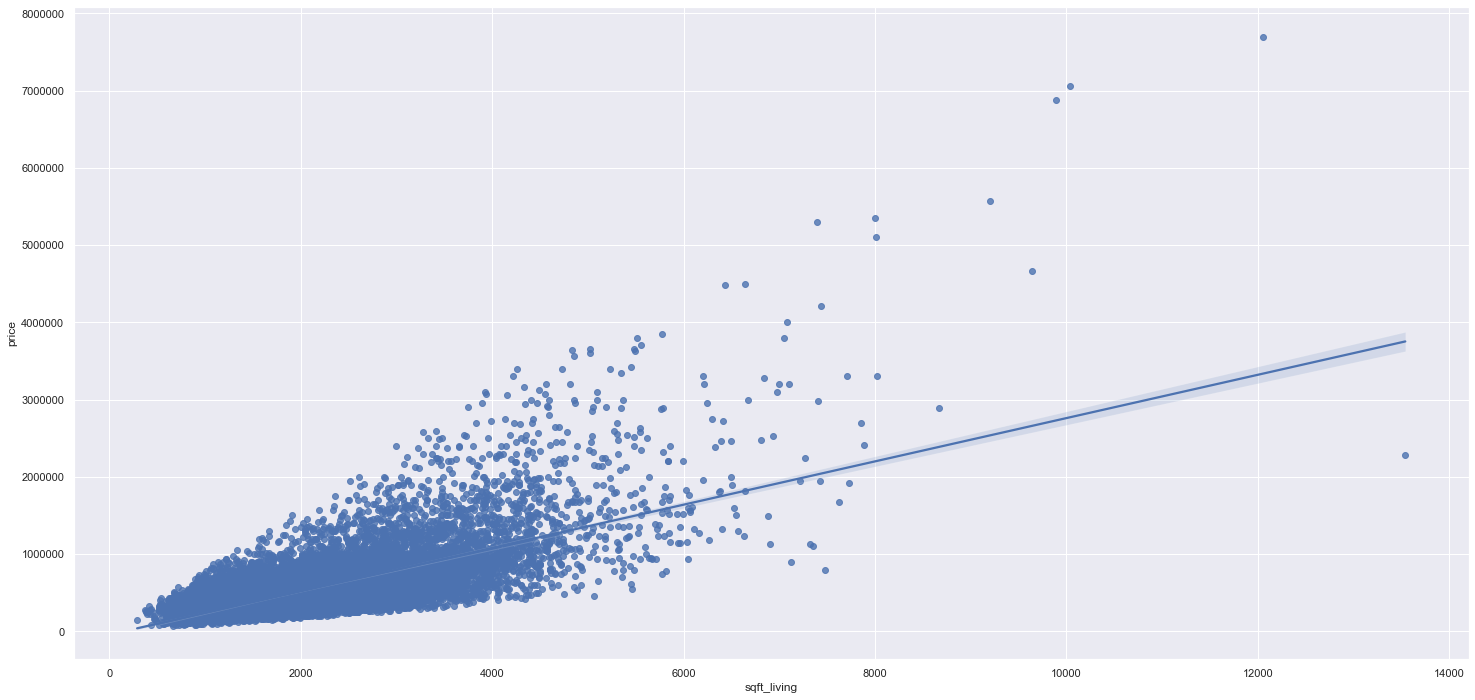

In [36]:
aux = df4[['sqft_living', 'price']]
sns.regplot(data=aux, x='sqft_living', y='price')
plt.ticklabel_format(style='plain', axis='y');

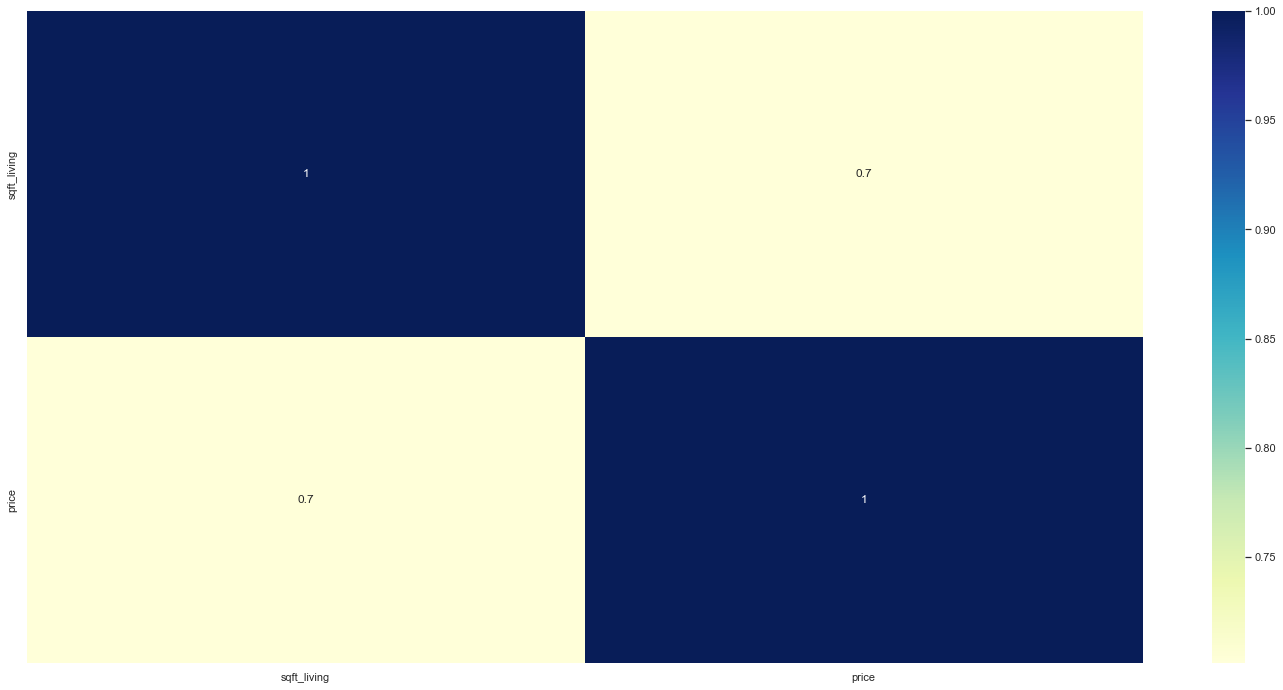

In [37]:
sns.heatmap(aux.corr(method='pearson'), annot=True, cmap='YlGnBu');

### H4. Propriedades térreas são mais caras

#### FALSE

As propriedades com apenas 1 andar são as com o menor preço médio de vendas. Entretanto, é correto afirmar também que as propriedades com mais andares (3,5 andares) não as com maior preço médio de venda.  
Posto esse ocupado por propriedades com 2.5 andares.

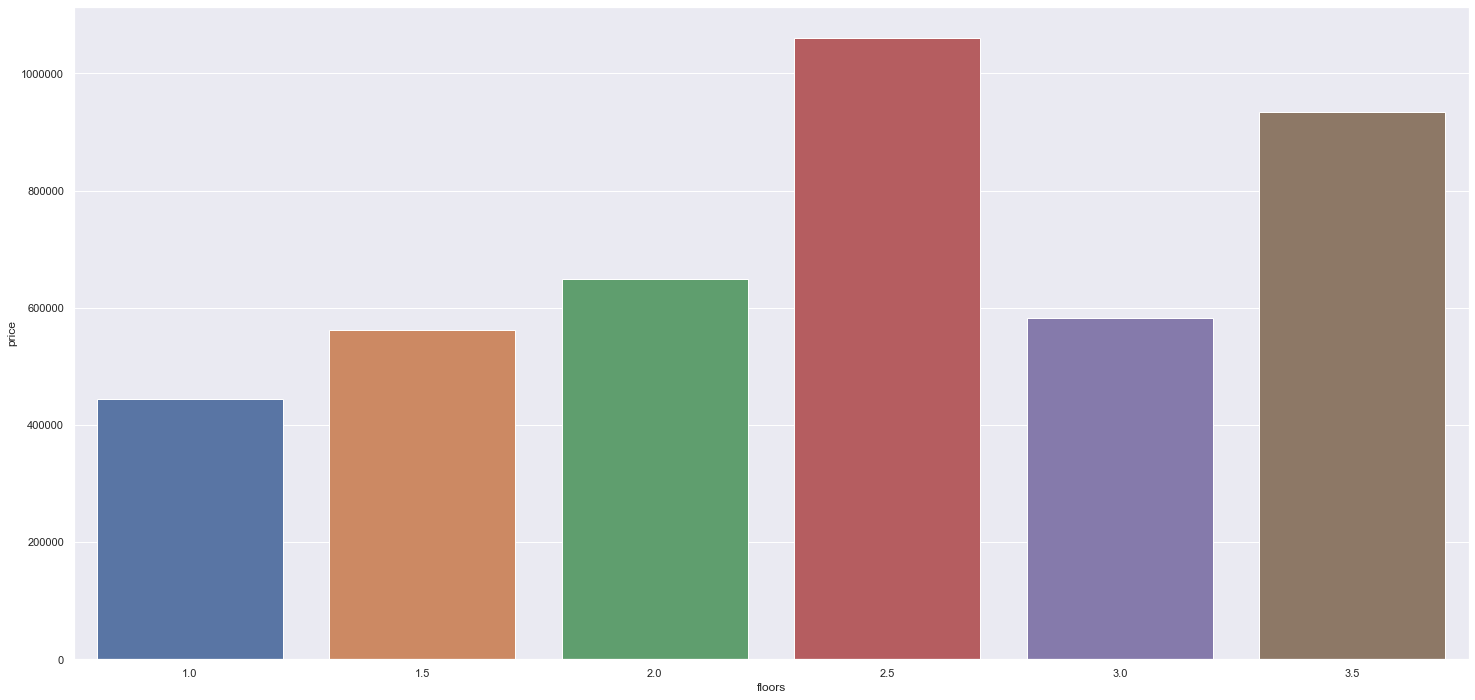

In [38]:
aux = df4[['floors', 'price']].groupby('floors', as_index=False).mean()
sns.barplot(data=aux, x='floors', y='price')
plt.ticklabel_format(style='plain', axis='y');

### H5. Propriedades em más condições são mais baratas

#### TRUE

Realmente, propriedades em más condições são as com menor valor médio de venda.

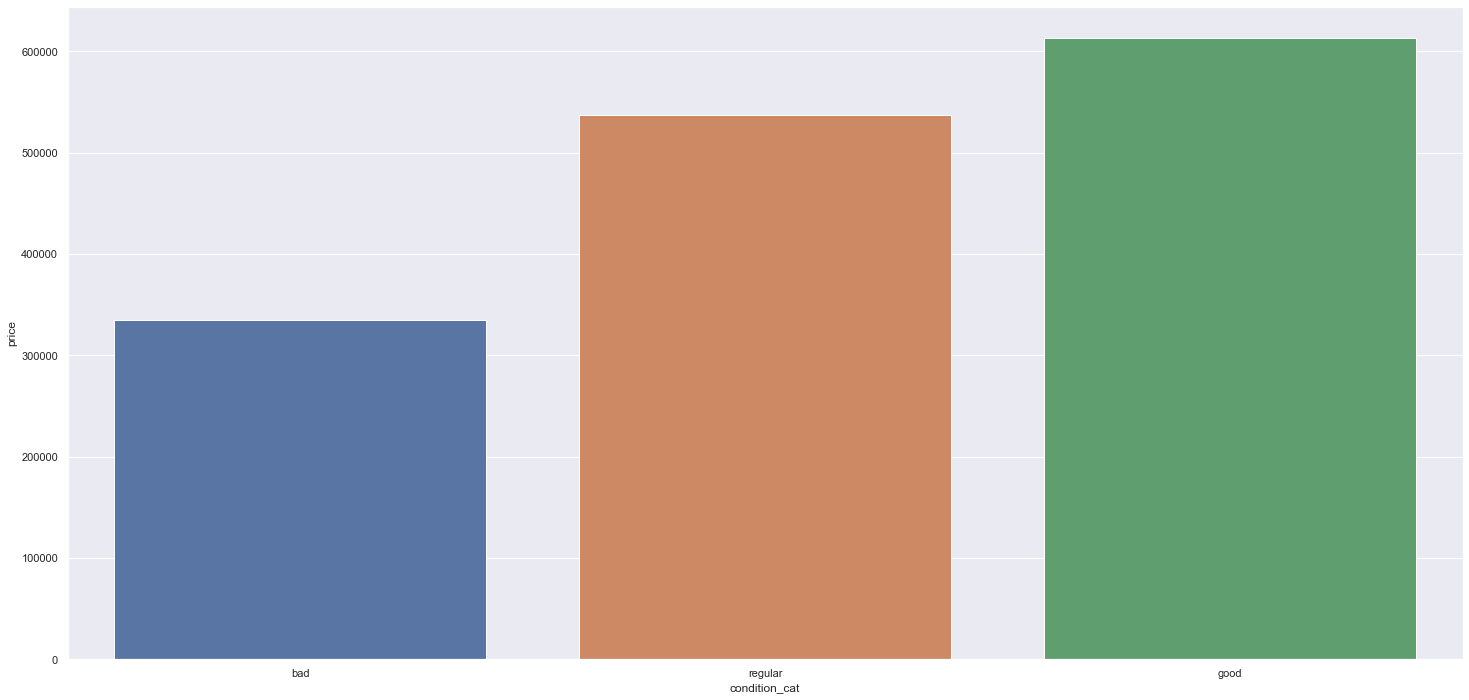

In [39]:
aux = df4[['condition_cat', 'price']].groupby('condition_cat', as_index=False).mean()
sns.barplot(data=aux, x='condition_cat', y='price', order=['bad', 'regular', 'good'])
plt.ticklabel_format(style='plain', axis='y');

### H6. Propriedades de alto padrão são mais caras

#### TRUE

Propriedades de alto padrão tem o preço médio de venda 3 vezes maior do que o preço médio de venda de propriedades de padrão médio.

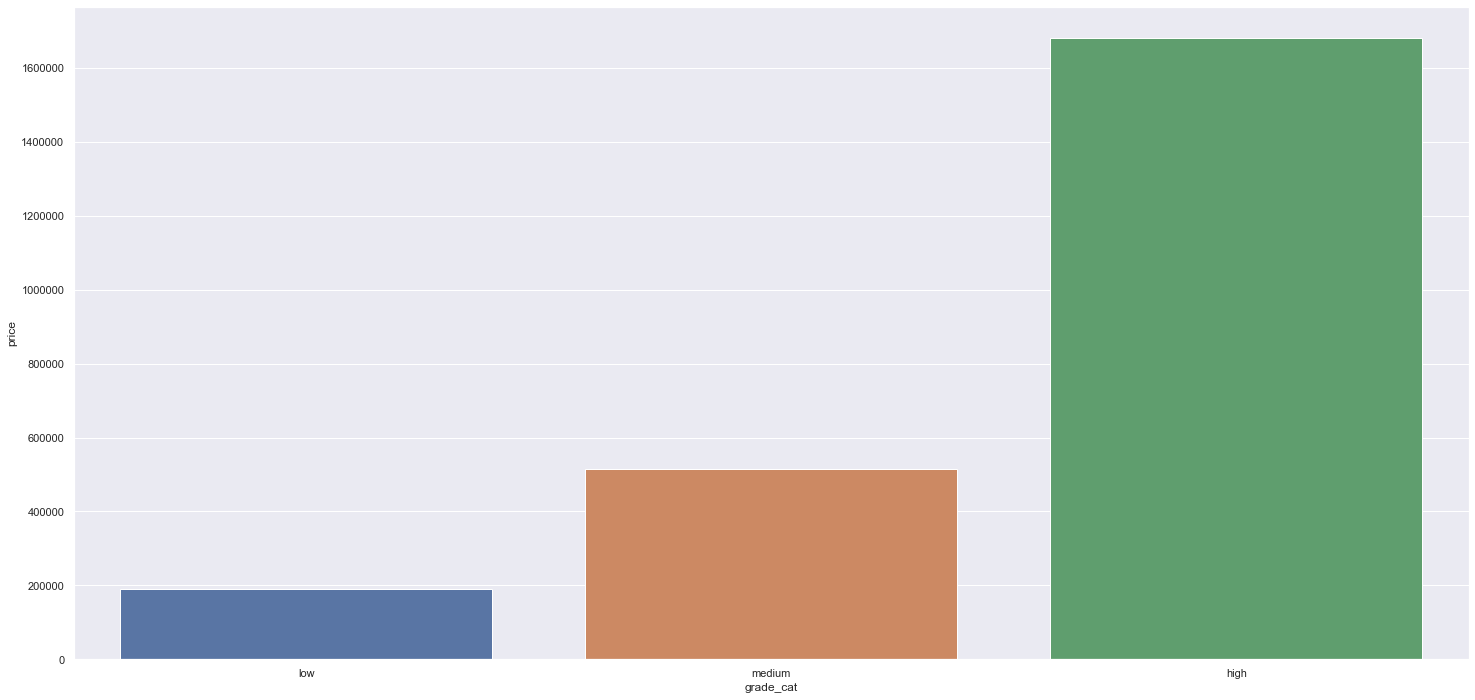

In [40]:
aux = df4[['grade_cat', 'price']].groupby('grade_cat', as_index=False).mean()
sns.barplot(data=aux, x='grade_cat', y='price', order=['low', 'medium', 'high'])
plt.ticklabel_format(style='plain', axis='y');

In [41]:
high, low, medium = aux['price']

high_over_low = ((high / low) - 1) * 100
high_over_medium = ((high / medium) - 1) * 100
medium_over_low = ((medium / low) - 1) * 100

print(f'Diferença em percentual das faixas de padrão:')
print(f'alto padrão > médio padrão: {high_over_medium:.1f}%')
print(f'médio padrão> baixo padrão: {medium_over_low:.1f}%')
print(f'alto padrão > baixo padrão: {high_over_low:.1f}%')

Diferença em percentual das faixas de padrão:
alto padrão > médio padrão: 226.8%
médio padrão> baixo padrão: 171.2%
alto padrão > baixo padrão: 786.3%


### H7. Propriedades de alto padrão mesmo em más condições são mais caras do que propriedades de baixo padrão em boas condições

#### INCONCLUSIVE

Não há propriedades de alto padrão em más condições, portanto não é possível validar ou invalidar a hipótese.

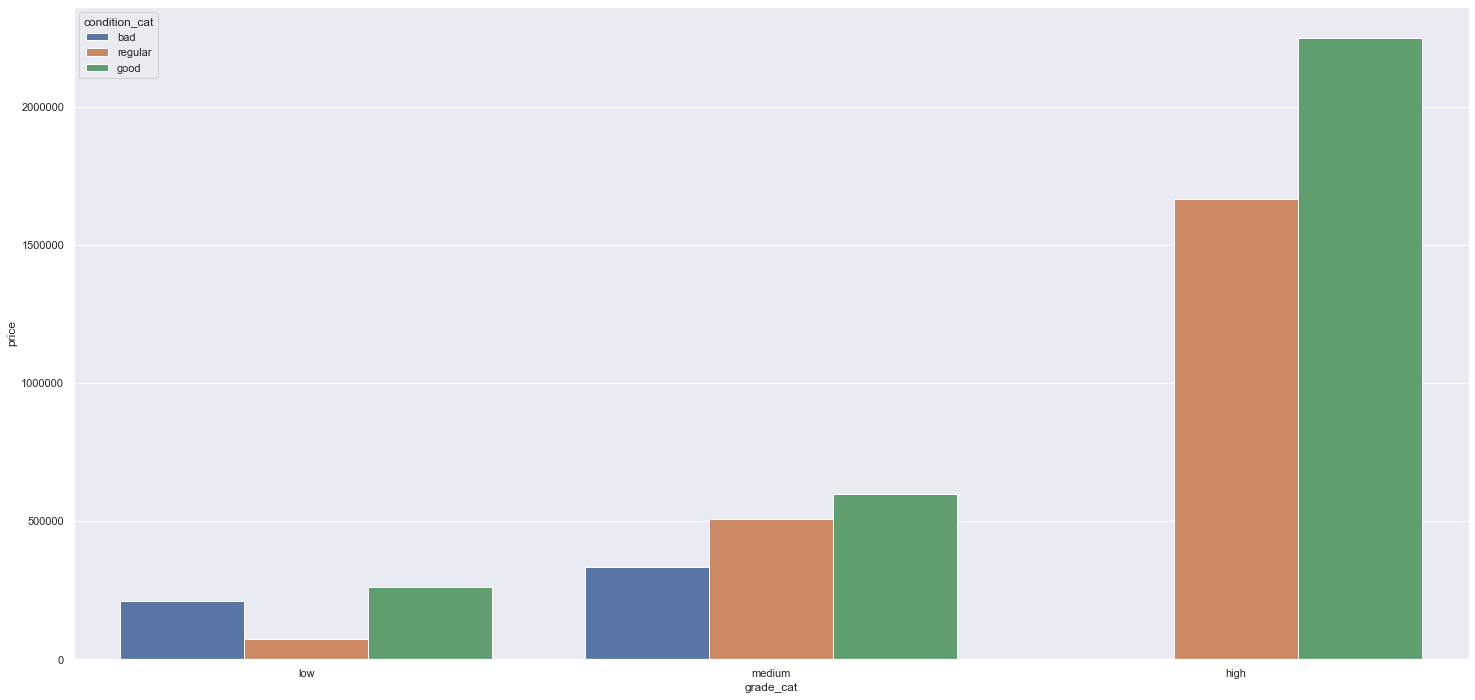

In [42]:
grade_order = ['low', 'medium', 'high']
condition_order = ['bad', 'regular', 'good']

aux = df4[['grade_cat', 'condition_cat', 'price']].groupby(['grade_cat', 'condition_cat'], as_index=False).mean()
sns.barplot(data=aux, x='grade_cat', y='price', hue='condition_cat', order=grade_order, hue_order=condition_order)
plt.ticklabel_format(style='plain', axis='y');

In [43]:
df4.loc[df4['grade_cat'] == 'high', ['condition_cat', 'price']].groupby('condition_cat', as_index=False).mean()

,condition_cat,price
0,good,2249517.86
1,regular,1665357.60


### H8. Propriedades com vista para o lago com qualquer qualidade são mais caras do que propriedades com vista da melhor qualidade

#### FALSE

As propriedades com vista para o lago mas com má qualidade de vista não são mais caras, na média, do que as propriedades sem vista para o lago com qualidade de vista regular ou boa.

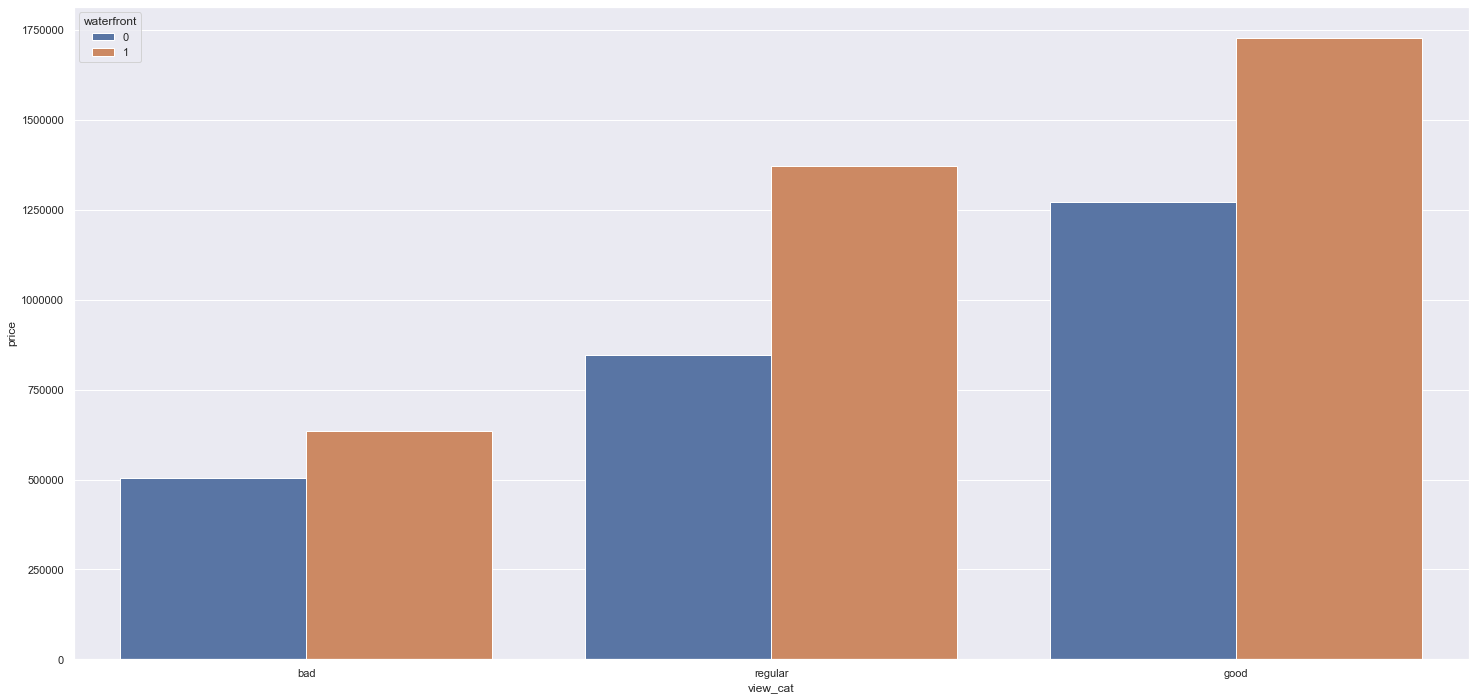

In [44]:
aux = df4[['waterfront', 'view_cat', 'price']].groupby(['waterfront', 'view_cat'], as_index=False).mean()
sns.barplot(data=aux, x='view_cat', y='price', hue='waterfront', order=['bad', 'regular', 'good'])
plt.ticklabel_format(style='plain', axis='y');

### H9. Propriedades de alto padrão com vista para o lago e de boa qualidade e em boas condições são raras, compõem apenas 10% da base

#### TRUE

Realmente raras! Menos de 1% das propriedades se encontram nessas condições.

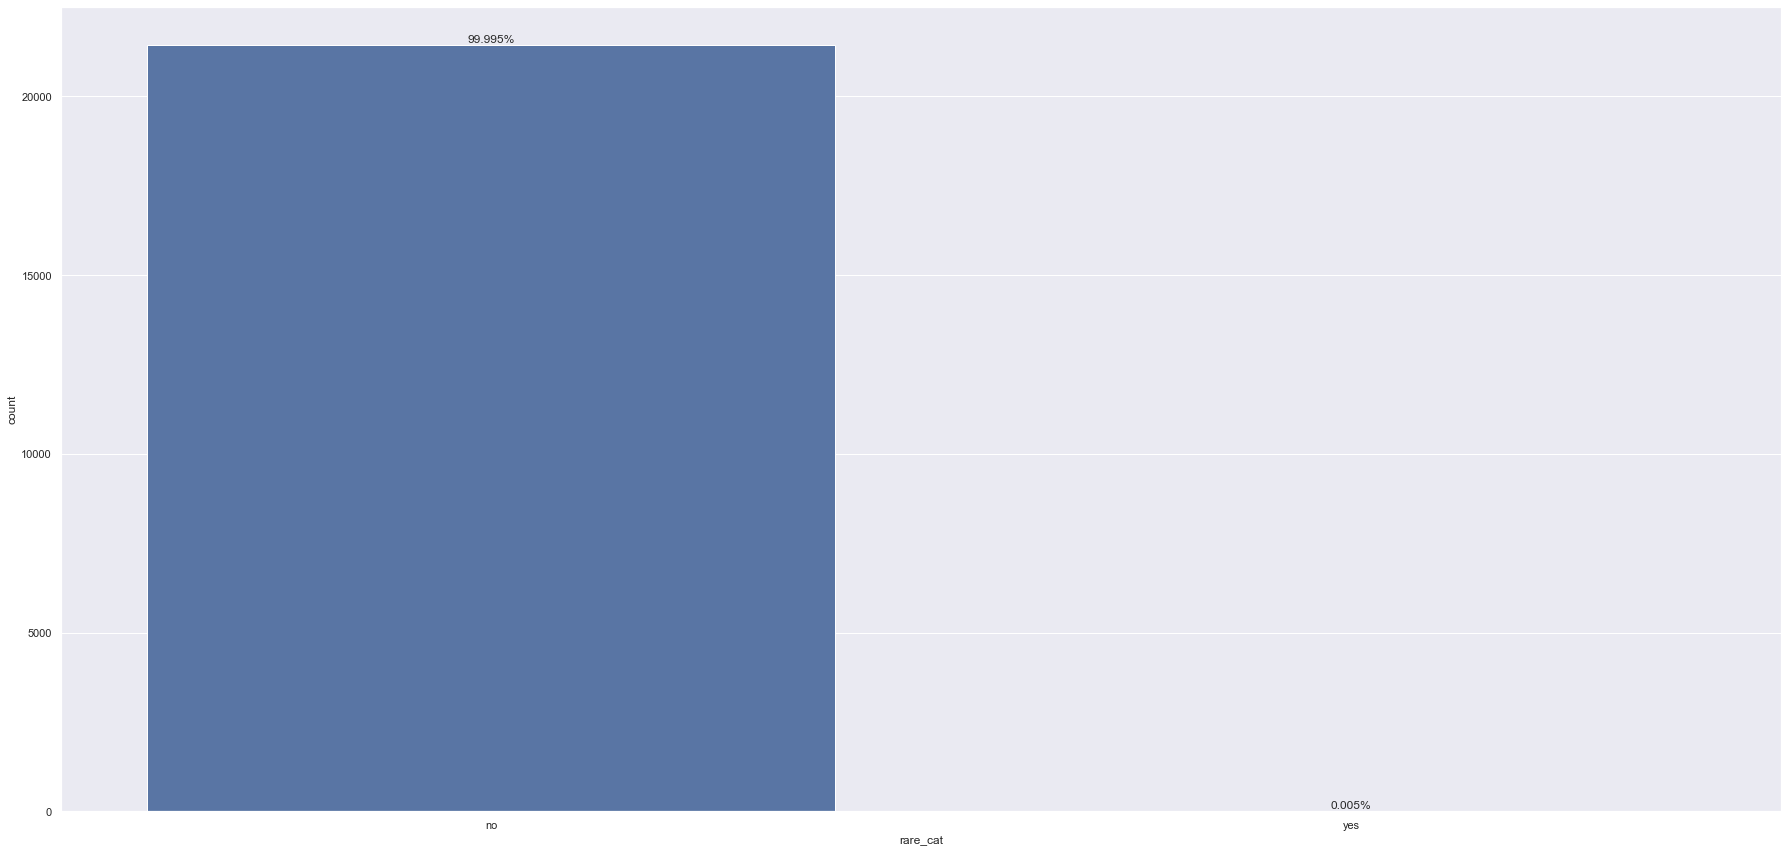

In [45]:
aux = df4[['id', 'grade_cat', 'waterfront_cat', 'view_cat', 'condition_cat', 'price']].copy()
aux['rare_cat'] = aux.apply(lambda x: 'yes'
                                if ((x['grade_cat'] == 'high') &
                                   (x['waterfront_cat'] == 'yes') &
                                   (x['view_cat'] == 'good') &
                                   (x['condition_cat'] == 'good'))
                                else 'no', axis=1)

ax = sns.countplot(data=aux, x='rare_cat')

total = len(aux)
for p in ax.patches:
    perc = f"{100 * p.get_height() / total:.3f}%\n"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(perc, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

### H10. O preço das casas diminui com a idade

#### FALSE

A tendência do preço médio de venda com a evolução dos anos mostra pouca angulação no eixo y.  
Além disso, a correlação entre preço e ano de construção é bem baixa, quase 0.

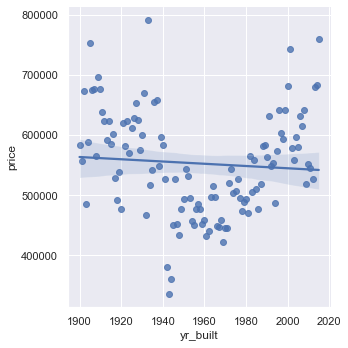

In [46]:
aux = df4[['yr_built', 'price']].groupby('yr_built', as_index=False).mean()
sns.lmplot(data=aux, x='yr_built', y='price');

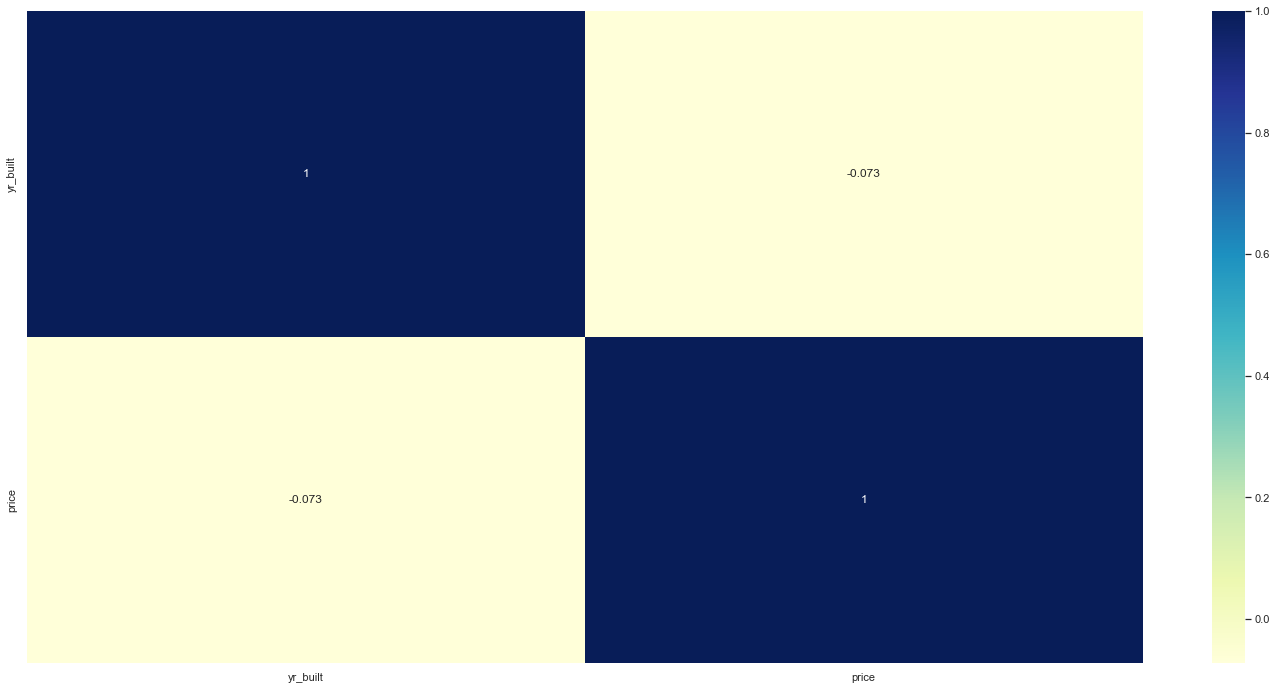

In [47]:
sns.heatmap(aux.corr(method='pearson'), annot=True, cmap='YlGnBu');

### H11. Propriedades com vista para o lago são vendidas no verão por 15% a mais no valor médio de venda do que em outras estações.

#### FALSE

O preço médio de venda para propriedades com vista para o lago no verão é maior em 15% apenas quando comparado com o inverno. 

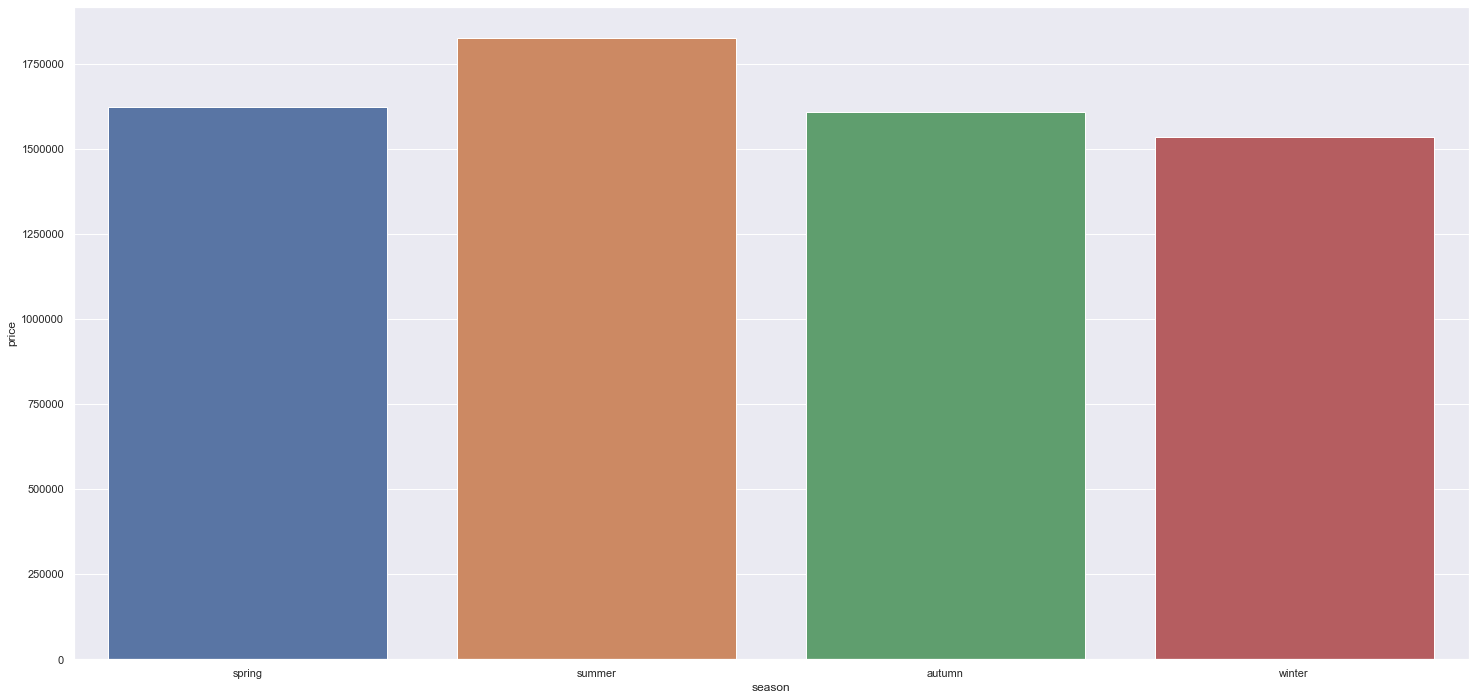

In [48]:
aux = df4.loc[df4['waterfront_cat'] == 'yes', ['season', 'price']].groupby(['season'], as_index=False).mean()
sns.barplot(data=aux, x='season', y='price', order=['spring', 'summer', 'autumn', 'winter'])
plt.ticklabel_format(style='plain', axis='y');

In [49]:
autumn, spring, summer, winter = aux['price']
summer_over_autumn = ((summer / autumn) - 1) * 100
summer_over_spring = ((summer / spring) - 1) * 100
summer_over_winter = ((summer / winter) - 1) * 100

print(f'Percentual do preço médio de venda:')
print(f'Verão > Outono: {summer_over_autumn:.1f}%')
print(f'Verão > Primavera: {summer_over_spring:.1f}%')
print(f'Verão > Inverno: {summer_over_winter:.1f}%')

Percentual do preço médio de venda:
Verão > Outono: 13.5%
Verão > Primavera: 12.5%
Verão > Inverno: 19.0%


### H12. No geral, a época do ano não gera mais de 5% de variação no preço médio de venda entre as estações.

#### FALSE

No inverno o preço médio de venda é menor do que na primavera e no verão e mais de 5%.

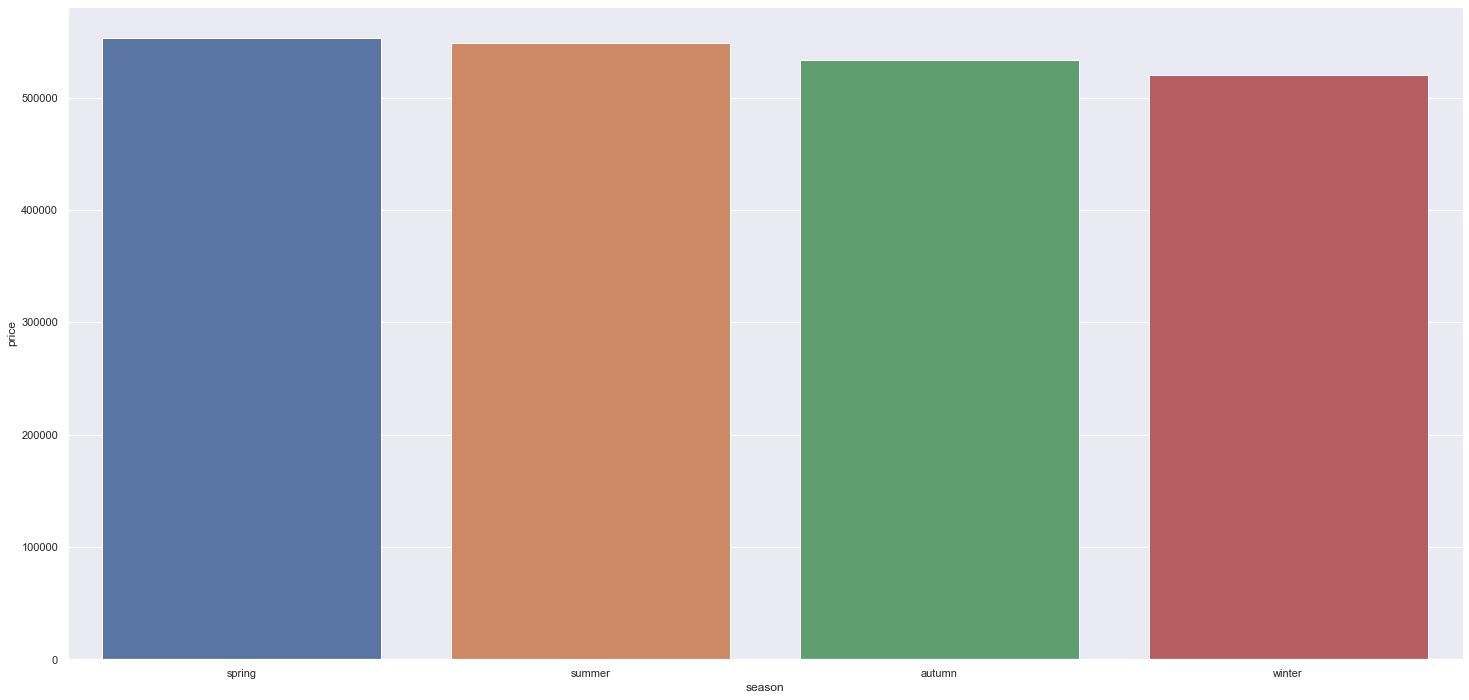

In [50]:
aux = df4[['season', 'price']].groupby('season', as_index=False).mean()
sns.barplot(data=aux, x='season', y='price', order=['spring', 'summer', 'autumn', 'winter']);

In [51]:
d1 = dict(zip(aux['season'], aux['price']))
d2 = d1.copy()

print(f'Variação entre estações:')

for k1, v1 in d1.items():
  d2.pop(k1)
  for k2, v2 in d2.items():
    variation = ((v1 / v2) -1) * 100
    print(f'{k1} -> {k2}: {variation:.1f}%')

Variação entre estações:
autumn -> spring: -3.5%
autumn -> summer: -2.8%
autumn -> winter: 2.6%
spring -> summer: 0.7%
spring -> winter: 6.3%
summer -> winter: 5.5%


## 4.3. Análise multivariada

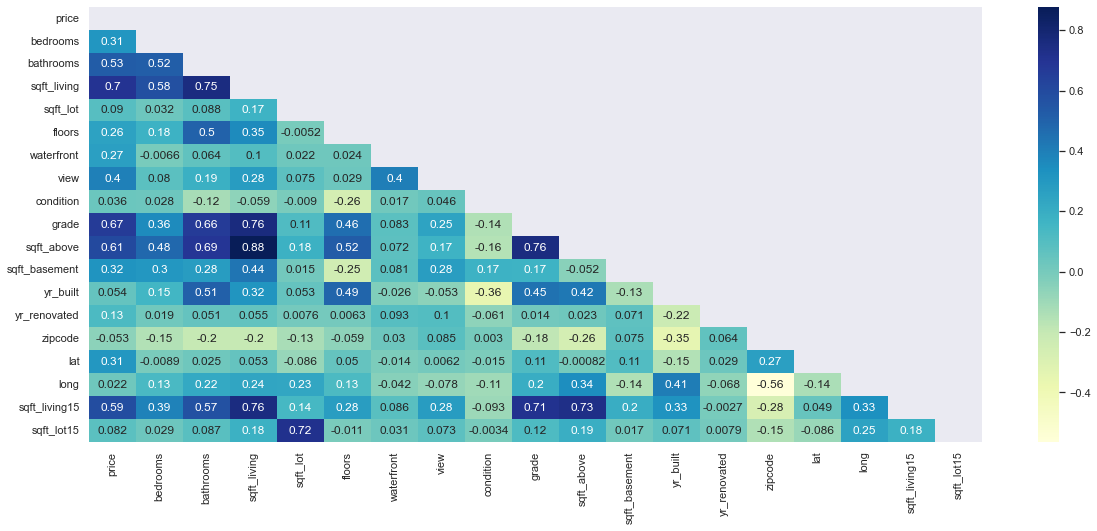

In [52]:
plt.figure(figsize=(20,8))

corr = num_attributes.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, cmap='YlGnBu', annot=True, mask=mask);

Correlação forte encontrada em a feature de preço (PRICE) com:
- bathrooms
- sqft_living
- grade
- sqft_above
- sqft_living15

Além disso, a feature sqft_above será desconsiderada nos ciclos posteriores por conta da forte relação dela com o sqft_living. E sqft_living foi a escolhida para seguir com a modelagem

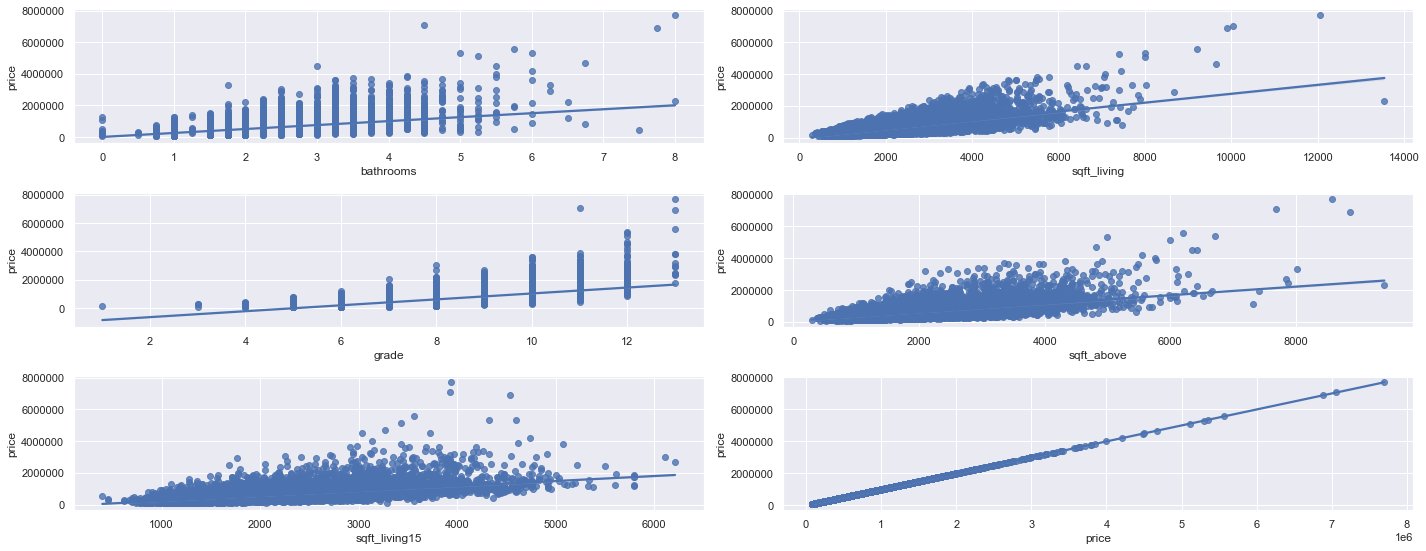

In [53]:
strong_corr = ['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'price']

plt.figure(figsize=(20, 15))
x = 1
for f in strong_corr:
    plt.subplot(6, 2, x)
    sns.regplot(data = num_attributes[strong_corr], x = f, y = 'price')
    plt.ticklabel_format(style='plain', axis='y')
    x += 1

plt.tight_layout()

As features abaixo são as que entendo que são relevantes para o modelo por conta da variabilidade e correlação dos valores com a feature resposta:

- waterfront
- bedrooms
- sqft_living
- floors
- condition
- grade
- view
- yr_built
- date-season

# 5.0. Preparação dos dados

In [54]:
df5 = df4.copy()
df5.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_cat,view_cat,condition_cat,grade_cat,built_cat,season
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,no,bad,regular,medium,old,autumn
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639,no,bad,regular,medium,old,winter
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062,no,bad,regular,medium,old,winter
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000,no,bad,good,medium,old,winter
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503,no,bad,regular,medium,old,winter


## 5.1. Normalização

A normalização não será aplicada já que as features não tem distribuição normal (ou Gaussiana).

## 5.2. Rescala

Vou optar pelo robust scale para features com muitos possíveis outliers e minmax para os demais.  
Features para rescala com **robust**:
- price
- bedrooms
- bathrooms
- sqft_living
- sqft_lot
- floors
- view
- condition  

Features para rescala com **minmax**:
- grade
- sqft_above
- sqft_basement
- yr_built
- yr_renovated
- zipcode
- lat
- long
- sqft_living15
- sqft_lot15

In [55]:
# Rescala das features com robust scaler
rs = RobustScaler()

df5['bedrooms'] = rs.fit_transform(df5[['bedrooms']].values)
df5['bathrooms'] = rs.fit_transform(df5[['bathrooms']].values)
df5['sqft_living'] = rs.fit_transform(df5[['sqft_living']].values)
df5['sqft_lot'] = rs.fit_transform(df5[['sqft_lot']].values)
df5['sqft_above'] = rs.fit_transform(df5[['sqft_above']].values)
df5['sqft_basement'] = rs.fit_transform(df5[['sqft_basement']].values)
df5['sqft_living15'] = rs.fit_transform(df5[['sqft_living15']].values)
df5['sqft_lot15'] = rs.fit_transform(df5[['sqft_lot15']].values)

# Rescala das features com minmax scaler
mms = MinMaxScaler()

df5['floors'] = rs.fit_transform(df5[['floors']].values)
df5['view'] = rs.fit_transform(df5[['view']].values)
df5['condition'] = rs.fit_transform(df5[['condition']].values)
df5['grade'] = rs.fit_transform(df5[['grade']].values)
df5['yr_built'] = rs.fit_transform(df5[['yr_built']].values)
df5['yr_renovated'] = mms.fit_transform(df5[['yr_renovated']].values)
df5['zipcode'] = rs.fit_transform(df5[['zipcode']].values)
df5['lat'] = rs.fit_transform(df5[['lat']].values)
df5['long'] = rs.fit_transform(df5[['long']].values)

## 5.3. Transformação

### 5.3.1. Encoding

In [56]:
# Encoder das features categóricas
df5 = pd.get_dummies(df5, prefix=['season'], columns=['season'])

# 6.0. Seleção de dados

In [57]:
df6 = df5.copy()

## 6.1. Divisão dos dados em treino e teste

In [58]:
X = df6.drop(columns=['id', 'date'])
y = df6['price']

# divisão em 75%, 25% (treino e teste)
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'df6: {df6.shape} | 75% = {df6.shape[0] * 0.75} | 25% = {df6.shape[0] * 0.25}')
print(f'x_train: {x_train_split.shape}')
print(f'x_test: {x_test_split.shape}')
print(f'y_train: {y_train_split.shape}')
print(f'y_test: {y_test_split.shape}')

df6: (21436, 30) | 75% = 16077.0 | 25% = 5359.0
x_train: (16077, 28)
x_test: (5359, 28)
y_train: (16077,)
y_test: (5359,)


## 6.2. Seleção automatizada de features

Não vou executar neste ciclo, no próximo vou utilizar, provavelmente, o boruta

## 6.3. Seleção manual de features

Features descartadas:
- sqft_above => que tem uma alta correlação com sqft_living
- date => foi transformada em estação
- id => não relevante para previsão
- waterfront_cat => vou utilizar a escala original dos dados
- view_cat => vou utilizar a escala original dos dados
- condition_cat => vou utilizar a escala original dos dados
- grade_cat => vou utilizar a escala original dos dados
- built_cat => vou utilizar a escala original dos dados

In [59]:
cols_selected = [
     'bedrooms',
     'bathrooms',
     'sqft_living',
     'sqft_lot',
     'floors',
     'waterfront',
     'view',
     'condition',
     'grade',
     'sqft_basement',
     'yr_built',
     'yr_renovated',
     'zipcode',
     'lat',
     'long',
     'sqft_living15',
     'sqft_lot15',
     'season_autumn',
     'season_spring',
     'season_summer',
     'season_winter'
]

# 7.0. Modelo de machine learning

In [60]:
x_train = x_train_split[cols_selected]
y_train = y_train_split

x_test = x_test_split[cols_selected]
y_test = y_test_split

x_training = x_train_split

## 7.1. Baseline - Modelo de média

In [61]:
aux1 = x_test.copy()
aux1['price'] = y_test

# prevendo o valor médio
aux1['prediction'] = aux1['price'].mean()

# separando a previsão do modelo de média para análise do erro
yhat_bl = aux1['prediction']

# performance
bl_result = ml_error('Average Model', y_test, yhat_bl)
bl_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,227104.46,0.53,347781.93


## 7.2.1. Regressão linear

In [62]:
# definição
lr = LinearRegression()

# treino
lr.fit(x_train, y_train)

# previsão
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', y_test, yhat_lr)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,123981.87,0.26,193639.14


## 7.2.2. Regressão Linear - validação cruzada

In [63]:
lr_cross = cross_validate(lr, x_train, y_train, cv=5, scoring=score_metrics)

lr_cross_result = ml_cross_validation_error(lr_cross, 'Linear Regression CV')
lr_cross_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression CV,-127535.88 +/- 1395.32,-0.26 +/- 0.01,-204141.68 +/- 4197.0


## 7.3.1. Lasso

In [64]:
# definição
lrr = Lasso(alpha=0.01, tol=1e-1)

# treino
lrr.fit(x_train, y_train)

# previsão
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', y_test, yhat_lrr)
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,123981.86,0.26,193639.13


## 7.3.2. Lasso - validação cruzada

In [65]:
lrr_cross = cross_validate(lrr, x_train, y_train, cv=5, scoring=score_metrics)

lrr_cross_result = ml_cross_validation_error(lrr_cross, 'Lasso CV')
lrr_cross_result

,Model Name,MAE,MAPE,RMSE
0,Lasso CV,-127535.86 +/- 1395.32,-0.26 +/- 0.01,-204141.68 +/- 4197.0


## 7.4.1. Random Forest Regressor

In [66]:
# definição
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

# treino
rf.fit(x_train, y_train)

# previsão
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,65296.48,0.13,121710.28


## 7.4.2. Random Forest Regressor - validação cruzada

In [67]:
rf_cross = cross_validate(rf, x_train, y_train, cv=5, scoring=score_metrics)

rf_cross_result = ml_cross_validation_error(rf_cross, 'Random Forest Regressor CV')
rf_cross_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor CV,-69822.94 +/- 1020.41,-0.13 +/- 0.0,-133230.05 +/- 6720.55


## 7.5.1. XGBoost

In [68]:
# definição
xg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9
)

# treino
xg.fit(x_train, y_train)

# previsão
yhat_xg = xg.predict(x_test)

# performance
xg_result = ml_error('XGBoost Regressor', y_test, yhat_xg)
xg_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,201134.46,0.35,271637.16


## 7.5.2. XGBoost - validação cruzada

In [69]:
xg_cross = cross_validate(xg, x_train, y_train, cv=5, scoring=score_metrics)
xg_cross_result = ml_cross_validation_error(xg_cross, 'XGBoost Regresssor CV')
xg_cross_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regresssor CV,-206865.48 +/- 1629.67,-0.35 +/- 0.0,-290529.53 +/- 6322.23


## 7.6. Comparação entre modelos

### 7.6.1. Performance em único treinamento

In [70]:
single_result = pd.concat([bl_result, lr_result, lrr_result, rf_result, xg_result])
single_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,65296.48,0.13,121710.28
0,Lasso,123981.86,0.26,193639.13
0,Linear Regression,123981.87,0.26,193639.14
0,XGBoost Regressor,201134.46,0.35,271637.16
0,Average Model,227104.46,0.53,347781.93


### 7.6.2. Performance com validação cruzada

In [71]:
cross_result = pd.concat([lr_cross_result, lrr_cross_result, rf_cross_result, xg_cross_result])
cross_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor CV,-69822.94 +/- 1020.41,-0.13 +/- 0.0,-133230.05 +/- 6720.55
0,Linear Regression CV,-127535.88 +/- 1395.32,-0.26 +/- 0.01,-204141.68 +/- 4197.0
0,Lasso CV,-127535.86 +/- 1395.32,-0.26 +/- 0.01,-204141.68 +/- 4197.0
0,XGBoost Regresssor CV,-206865.48 +/- 1629.67,-0.35 +/- 0.0,-290529.53 +/- 6322.23


Métricas utilizadas:
- **MAE** (mean absolute error) - Erro médio absoluto
    - É a média da diferença entre os valores previstos pelo modelo e os valores corretos (sabidos no dataset)  

- **MAPE** (mean absolute percetage error) - Erro percentual médio absoluto
    - É o percentual médio da diferença os valores previstos pelo modelo e os valores corretos (sabidos no dataset)  

- **RMSE** (root mean squared error) - Raíz quadrada do erro médio
    - É a raíz quadrada do erro médio , onde os erros são elevados ao quadrado (para evitar a anulação de valores positivos e negativos e depois é aplicada a raíz quadrada para devolver o erro para a escala padrão da previsão

O modelo que melhor performou foi o Random Forest Regressor.  
Então seguirei com ele.

# 8.0. Hiperparametrização do modelo

## 8.1. Random Search

In [72]:
## parâmetros
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
bootstrap = [True, False]

params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'bootstrap': bootstrap
}

params

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
 'bootstrap': [True, False]}

Este passo abaixo já rodou em carater efetivo e já tenho os resultados. 

Por conta do tempo de execução, será comentado até o ciclo 2, quando deverá ser executado novamente.

In [73]:
# # definição do modelo de árvore
# rf = RandomForestRegressor(random_state=42)

# # definição do modelo randômico
# rf_random = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=params,
#     n_iter=100,
#     cv=15,
#     n_jobs=-1,
#     random_state=42,
#     scoring=score_metrics,
#     refit='neg_root_mean_squared_error'
# )

# # treino
# rf_random.fit(x_train, y_train)

# print(f'Melhores parâmetros: {rf_random.best_params_}')

Melhores parâmetros:
- n_estimators: 450
- max_features: sqrt
- max_depth: 30
- bootstrap: False

## 8.2. Modelo Final

In [74]:
# definição
rf = RandomForestRegressor(n_estimators=450, max_features='sqrt', max_depth=30, bootstrap=False, n_jobs=-1, random_state=42)

# treino
rf.fit(x_train, y_train)

# previsão
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,66387.94,0.13,121614.25


# 9.0. Tradução do Erro

In [75]:
# df com todos os dados dos testes reescalados
df9 = x_test.copy()

# df base com o id e preço dos imóveis
aux1 = df6[['id', 'price']]

# junção do df de teste com o id e preço sabido (ocultado durante o teste)
df9 = df9.join(aux1)

# junção das predições adquiridas
df9['prediction'] = yhat_rf

df9.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,season_autumn,season_spring,season_summer,season_winter,id,price,prediction
6355,1.00,1.67,0.80,0.03,0.50,0,0.00,0.00,3.00,0.00,0.44,0.00,-0.73,0.24,0.17,0.90,0.06,0,1,0,0,4340000080,1450000.00,1322604.53
20958,1.00,0.67,-0.08,-0.74,0.50,0,0.00,0.00,1.00,0.00,0.82,0.00,1.58,-1.00,-0.38,-0.03,-0.84,0,0,1,0,4181200540,269800.00,311461.12
1226,0.00,-1.00,-0.64,0.76,-0.50,0,0.00,1.00,0.00,0.00,-0.16,0.00,-0.27,-1.10,0.73,-0.56,0.87,0,1,0,0,1842900030,234000.00,234784.44
1927,0.00,-0.67,-0.41,-0.22,-0.50,0,2.00,0.00,0.00,0.80,0.09,0.00,0.49,-0.20,-0.60,-0.50,-0.68,0,1,0,0,2113700335,316500.00,382339.71
17776,0.00,0.33,0.21,-0.29,0.00,0,0.00,1.00,1.00,0.50,-0.80,0.00,0.48,0.42,-0.25,0.52,-0.32,0,0,1,0,4217401240,990000.00,832208.17


## 9.1. Performance de Negócio

In [76]:
df91 = df9[['id', 'prediction']]

# MAE e MAPE
aux1 = df9[['id', 'price', 'prediction']].groupby('id').apply(lambda x: mean_absolute_error(x['price'], x['prediction'])).reset_index().rename(columns={0: 'MAE'})
aux2 = df9[['id', 'price', 'prediction']].groupby('id').apply(lambda x: mean_absolute_percentage_error(x['price'], x['prediction'])).reset_index().rename(columns={0: 'MAPE'})

# junção do MAE e MAPE com a base
aux3 = pd.merge(aux1, aux2, on='id', how='inner')
df92 = pd.merge(df91, aux3, on='id', how='inner')

# Cenários: Melhor (predição + erro) e Pior (predição - erro)
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario'] = df92['prediction'] + df92['MAE']

# Reordenando as colunas para uma tabela mais legível
df92 = df92[['id', 'prediction', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [77]:
df92.sort_values('prediction', ascending=False).head(10)

,id,prediction,worst_scenario,best_scenario,MAE,MAPE
4204,1225069038,4728745.67,2280000.00,7177491.33,2448745.67,1.07
794,1924059029,4250111.22,3832222.44,4668000.00,417888.78,0.09
2680,2470100110,3852792.84,2135585.69,5570000.00,1717207.16,0.31
4580,7558700030,3807836.87,2315673.73,5300000.00,1492163.13,0.28
1746,1346300150,2864248.56,2428497.11,3300000.00,435751.44,0.13
443,2525049148,2594573.58,1770347.16,3418800.00,824226.42,0.24
5234,7960900060,2534434.47,2168868.93,2900000.00,365565.53,0.13
2890,3625049014,2436464.32,1922928.64,2950000.00,513535.68,0.17
1343,2397101606,2364901.04,2099802.09,2630000.00,265098.96,0.10
2728,6447300365,2293855.00,1687710.00,2900000.00,606145.00,0.21


Dispersão dos erros

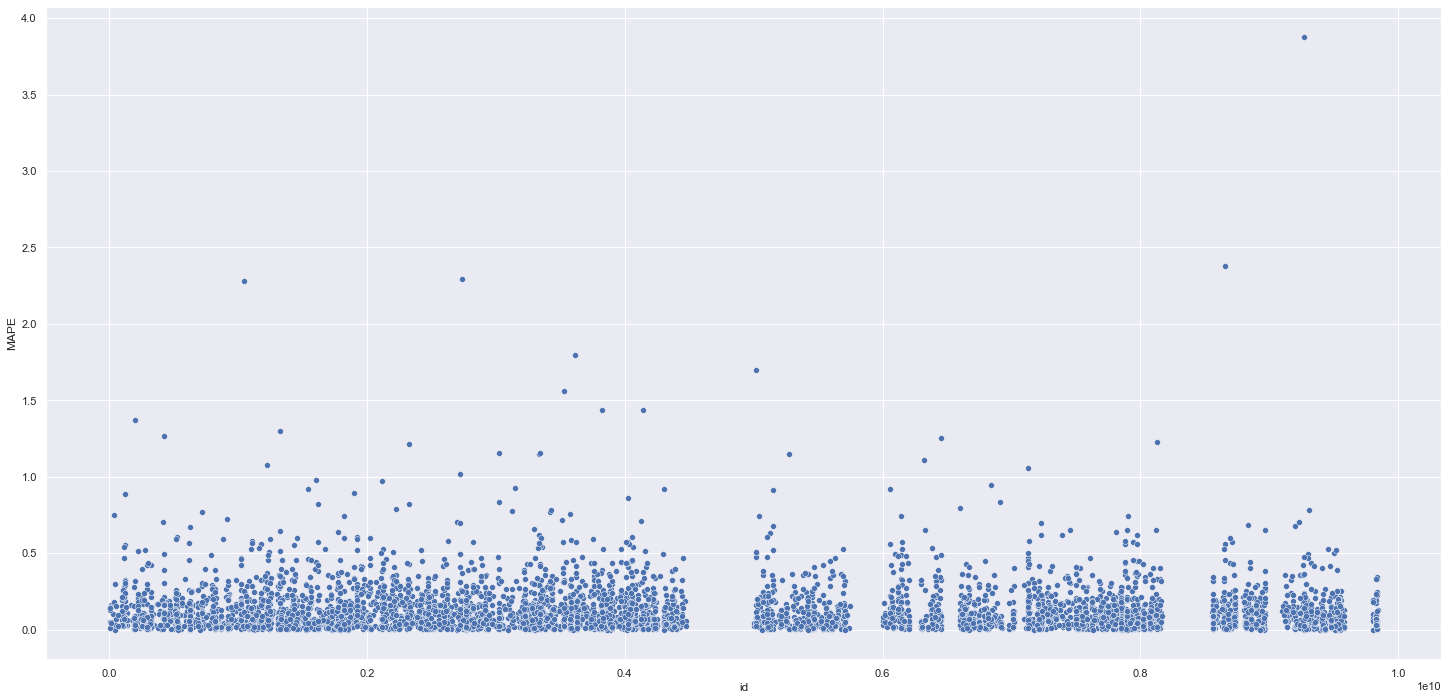

In [78]:
sns.scatterplot(x='id', y='MAPE', data=df92);

## 9.2. Performance Total

In [79]:
# Junção com o baseline (modelo de média dos dados totais testados)
df92['baseline'] = df9['price'].mean()

df93 = df92[['prediction', 'worst_scenario', 'best_scenario', 'baseline']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,prediction,"R$2,852,869,630.68"
1,worst_scenario,"R$2,497,096,653.22"
2,best_scenario,"R$3,208,642,608.14"
3,baseline,"R$2,853,209,128.00"


## 9.3. Performance do Modelo

In [80]:
df9['baseline'] = df9['price'].mean()
df9['error'] = df9['price'] - df9['prediction']
df9['error_rate'] = df9['prediction'] / df9['price']

Comparação dos preços previstos com o realizado e o baseline. 

É possível notar que o modelo errou mais nos maiores valores. Preciso voltar nestes pontos no próximo ciclo.

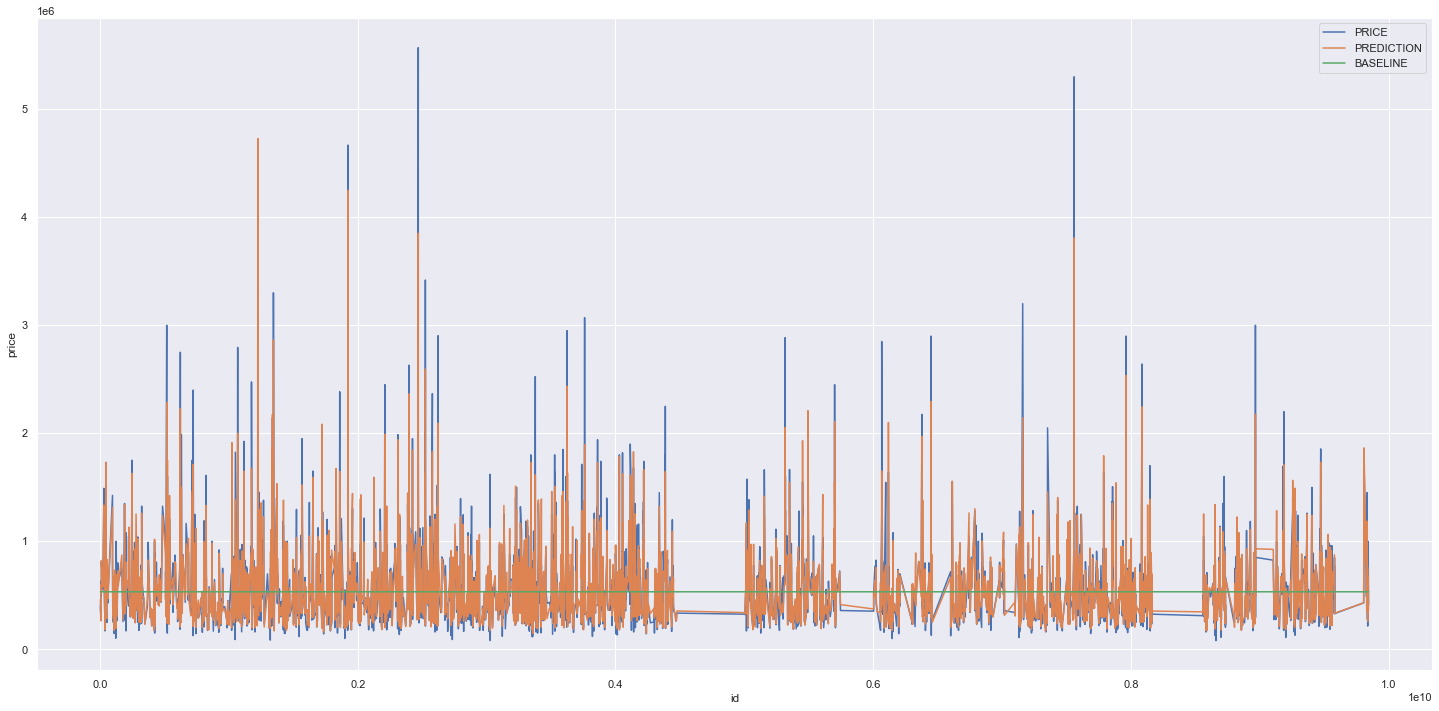

In [81]:
sns.lineplot(x='id', y='price', data=df9, label='PRICE')
sns.lineplot(x='id', y='prediction', data=df9, label='PREDICTION')
sns.lineplot(x='id', y='baseline', data=df9, label='BASELINE');

Distribuição dos erros

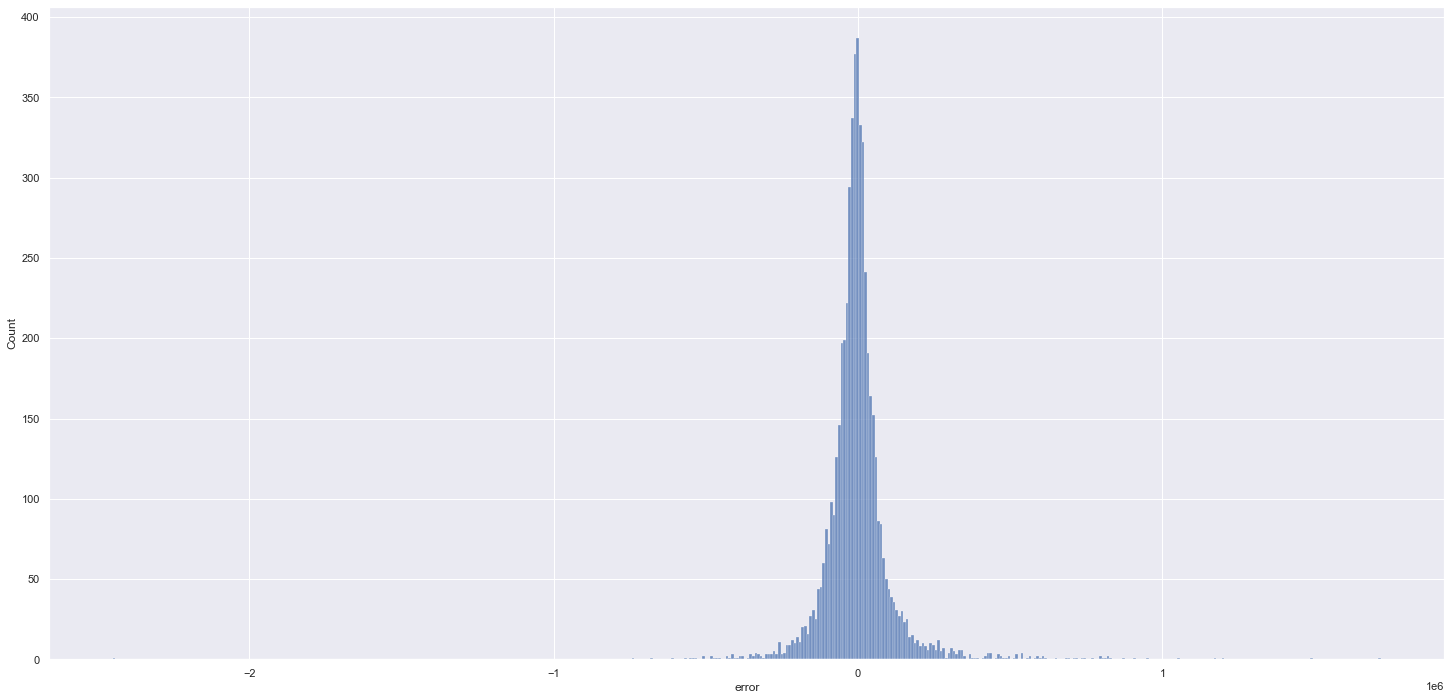

In [82]:
sns.histplot(df9['error']);

Distribuição do percentual do erro

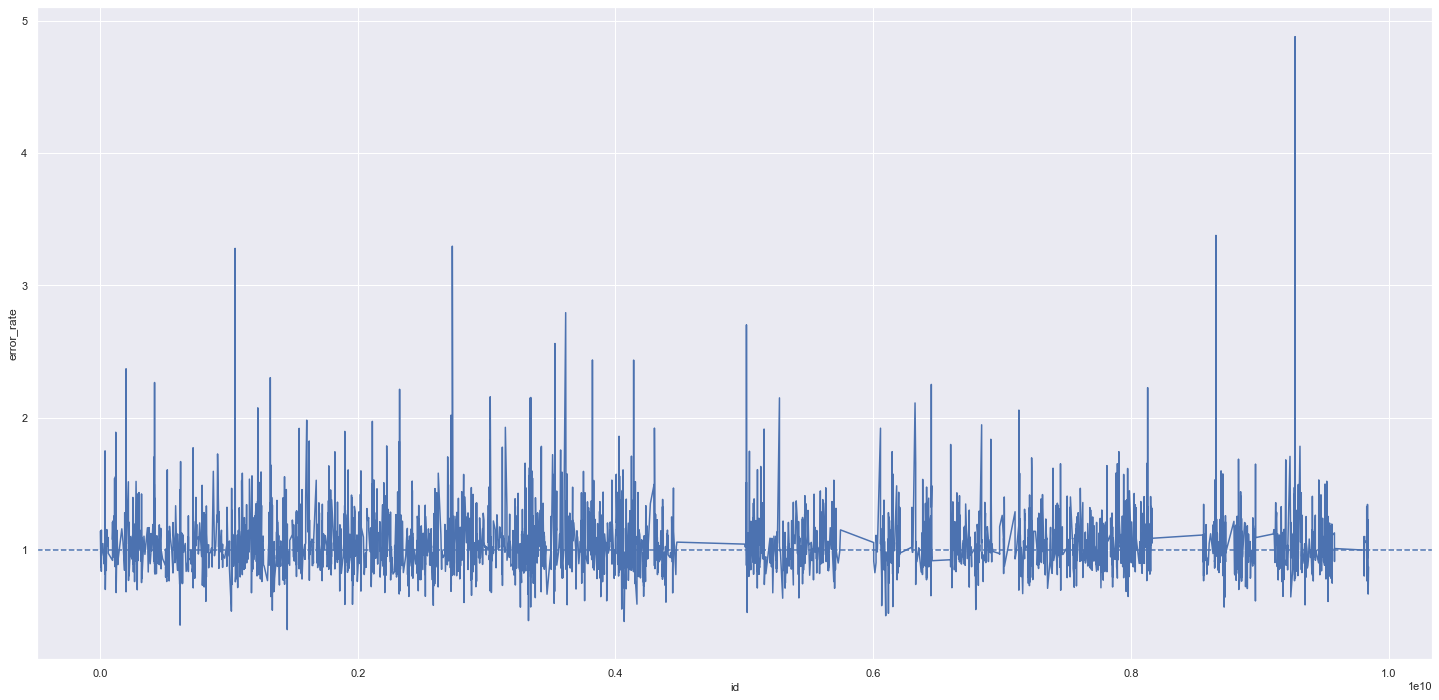

In [83]:
sns.lineplot(x='id', y='error_rate', data=df9)
plt.axhline(1, linestyle='--');

Disperção dos erros

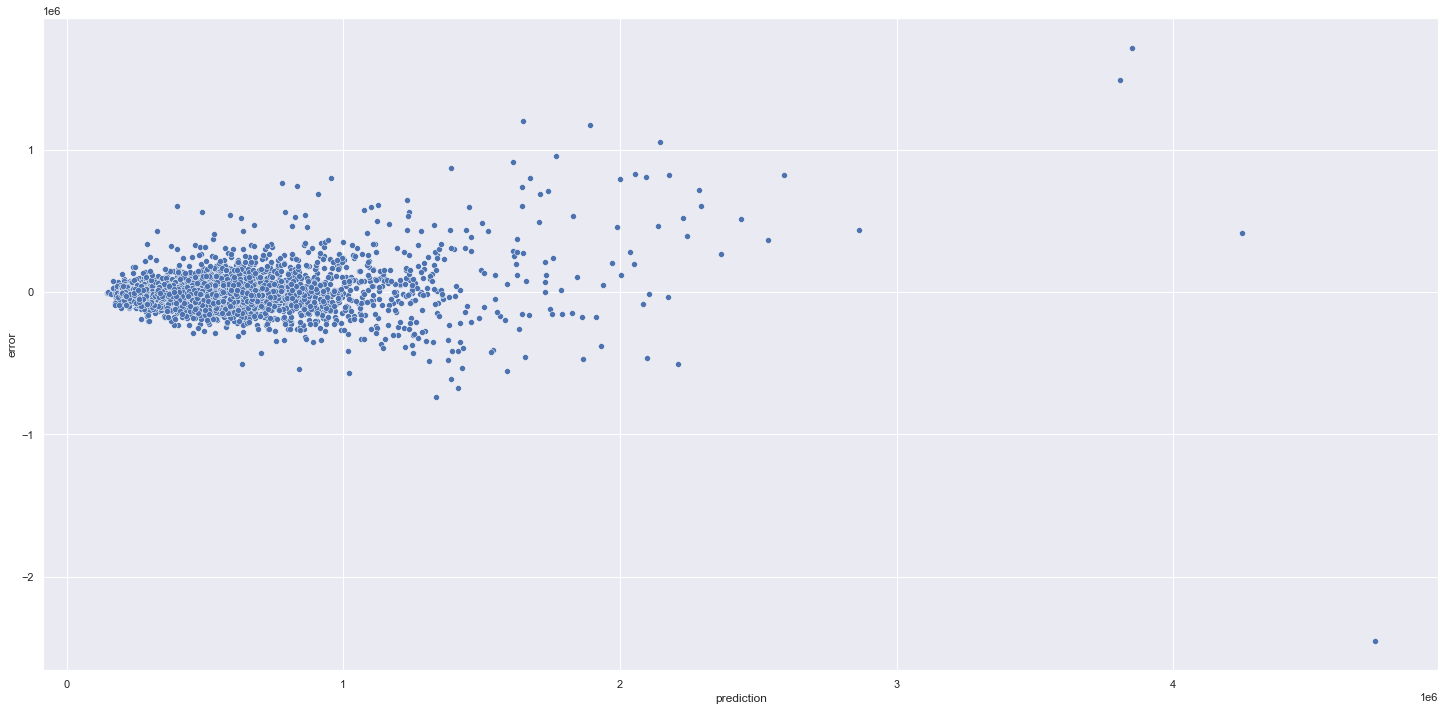

In [84]:
sns.scatterplot(x='prediction', y='error', data=df9);

# 10. Conclusão e próximos passos

## 10.1 Conclusão

In [95]:
df10 = df9[['id', 'price', 'prediction', 'baseline']].sort_values('prediction', ascending=False).head(10).reset_index()
df10['prediction_over_price'] = df10[['price', 'prediction']].apply(lambda x: (x['prediction'] / x['price'] * 100) - 100, axis = 1)
df10['baseline_over_price'] = df10[['price', 'baseline']].apply(lambda x: (x['baseline'] / x['price'] * 100) - 100, axis = 1)
df10[['id', 'prediction_over_price', 'baseline_over_price']]

,id,prediction_over_price,baseline_over_price
0,1225069038,107.40,-76.65
1,1924059029,-8.95,-88.59
2,2470100110,-30.83,-90.44
3,7558700030,-28.15,-89.95
4,1346300150,-13.20,-83.87
5,2525049148,-24.11,-84.43
6,7960900060,-12.61,-81.64
7,3625049014,-17.41,-81.95
8,2397101606,-10.08,-79.76
9,6447300365,-20.90,-81.64


O que podemos notar olhando a tabela acima é que os preços previstos neste primeiro ciclo estão mais próximos do preço real do que a média utilizada. 

Sendo assim, a probabilidade de venda é muito maior utilizando o preço previsto do que a média.

## 10.2. Próximos Passos

- Apresentar os resultados ao time de negócios
- Retornar à criação das features para talvez agrupar algumas informações
- Utilizar um selecionador de features para o modelo
- Tentar uma nova reescala dos dados
- Encontrar os novos hiperparâmetros para o modelo
- Retornar com a apresentação ao time de negócios